##import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pycaret

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
from sklearn.cluster import KMeans
from tqdm import tqdm



메소드

In [5]:
def check_holiday(target_df):
  # 주말 여부 확인하여 저장, 주말:true 평일:false
  target_df['holiday'] = target_df['일시'].dt.weekday >= 5

  # 한국의 공휴일 여부 확인하여 저장
  korea_holidays = holidays.KR()
  target_df['공휴일'] = target_df['일시'].apply(lambda x: x in korea_holidays)

  # 공휴일인 경우 holiday 값을 true로 변경
  target_df.loc[target_df['공휴일'], 'holiday'] = True

  return target_df

def make_ymd_feature(target_df):
  # 일시 데이터를 년, 월, 일, 시간으로 나누어 새로운 컬럼 추가
  #target_df['년'] = target_df['일시'].dt.year
  target_df['월'] = target_df['일시'].dt.month
  target_df['일'] = target_df['일시'].dt.day
  target_df['시간'] = target_df['일시'].dt.hour

  return target_df

# 불쾌지수 계산 함수 정의
def calculate_discomfort_index(temperature, humidity):
    return 0.81 * temperature + 0.01 * humidity * (0.99 * temperature - 14.3) + 46.3

def smape_fnc(true, pred):
  v = 2*abs(pred-true)/(abs(pred)+abs(true))
  output=np.mean(v)*100
  return output

## train 데이터

In [6]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/train.csv')

# 강수량, 일조, 일사 컬럼 삭제
df = df.drop(columns=['강수량(mm)', '일조(hr)', '일사(MJ/m2)'])

# 풍속과 습도 값이 NaN일 때 전 행의 값으로 치환
df['풍속(m/s)'].fillna(method='ffill', inplace=True)
df['습도(%)'].fillna(method='ffill', inplace=True)

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])


# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 년, 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 요일 컬럼 추가
df['요일'] = df['일시'].dt.dayofweek  # 요일을 0(월요일)부터 6(일요일)까지의 정수로 저장

# 컬럼 삭제
df.drop(columns=['num_date_time','공휴일','기온(C)'], inplace=True) # '일시'

# csv 파일로 저장
#df.to_csv('train_p.csv', index=False)
train_df = df.copy()

train_df

,건물번호,일시,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,시간,요일
0,1,2022-06-01 00:00:00,0.9,42.0,1085.28,0.314815,63.09388,True,6,1,0,2
1,1,2022-06-01 01:00:00,1.1,45.0,1047.36,0.292593,62.46400,True,6,1,1,2
2,1,2022-06-01 02:00:00,1.5,45.0,974.88,0.281481,62.08735,True,6,1,2,2
3,1,2022-06-01 03:00:00,1.4,48.0,953.76,0.244444,60.89884,True,6,1,3,2
4,1,2022-06-01 04:00:00,2.8,43.0,986.40,0.307407,62.88788,True,6,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,0.9,86.0,881.04,0.481481,72.38034,False,8,24,19,2
203996,100,2022-08-24 20:00:00,1.3,86.0,798.96,0.455556,71.21736,False,8,24,20,2
203997,100,2022-08-24 21:00:00,1.0,92.0,825.12,0.414815,69.79704,False,8,24,21,2
203998,100,2022-08-24 22:00:00,0.3,94.0,640.08,0.403704,69.41060,False,8,24,22,2


In [7]:
df.describe()

,건물번호,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,월,일,시간,요일
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,50.500000,2.134052,78.716518,2451.036462,0.571982,75.419692,6.929412,14.835294,11.500000,2.988235
std,28.866141,1.358146,15.080496,2440.648858,0.139982,5.460597,0.793923,8.446178,6.922204,1.991127
min,1.000000,0.000000,13.000000,0.000000,0.000000,50.481070,6.000000,1.000000,0.000000,0.000000
25%,25.750000,1.200000,69.000000,1085.760000,0.492593,72.551720,6.000000,8.000000,5.750000,1.000000
50%,50.500000,2.000000,81.000000,1766.400000,0.577778,76.268500,7.000000,15.000000,11.500000,3.000000
75%,75.250000,2.800000,91.000000,2970.000000,0.666667,79.366630,8.000000,22.000000,17.250000,5.000000
max,100.000000,13.300000,100.000000,25488.400000,1.000000,87.789790,8.000000,31.000000,23.000000,6.000000


In [8]:
train_df.columns.tolist()

['건물번호',
 '일시',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '요일']

## buliding_info 데이터

In [9]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/building_info.csv')

#  '-'인 경우 0으로 대체
df = df.replace('-', 0)

# 건물유형 원-핫 인코딩
one_hot_encoded = pd.get_dummies(df['건물유형'])
df = pd.concat([df, one_hot_encoded], axis=1)


from sklearn.preprocessing import LabelEncoder
# 라벨 인코더 생성 및 적용
label_encoder = LabelEncoder()
df['건물유형_라벨'] = label_encoder.fit_transform(df['건물유형'])+1


# 문자열을 숫자로 변환
df['태양광용량(kW)'] = df['태양광용량(kW)'].astype(float)
df['ESS저장용량(kWh)'] = df['ESS저장용량(kWh)'].astype(float)
df['PCS용량(kW)'] = df['PCS용량(kW)'].astype(float)

# 컬럼 삭제
df.drop(columns=['PCS용량(kW)'], inplace=True) #'건물유형'

#태양광 여부 컬럼 추가
df['태양광여부'] = df['태양광용량(kW)'] != 0

# csv 파일로 저장
#df.to_csv('building_info_p.csv', index=False)
binfo_df = df.copy()

binfo_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,건물기타,110634.00,39570.00,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,False
1,2,건물기타,122233.47,99000.00,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,False
2,3,건물기타,171243.00,113950.00,40.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,True
3,4,건물기타,74312.98,34419.62,60.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,True
4,5,건물기타,205884.00,150000.00,0.0,2557.0,1,0,0,0,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False
96,97,호텔및리조트,55144.67,25880.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False
97,98,호텔및리조트,53578.62,17373.75,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False
98,99,호텔및리조트,53499.00,40636.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False


In [10]:
sorted_df = df.sort_values(by='냉방면적(m2)')
sorted_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
65,66,아파트,1.050730e+05,0.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
67,68,아파트,3.893959e+05,0.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
64,65,아파트,1.838390e+05,0.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
76,77,지식산업센터,6.737714e+04,1.00,0.00,0.0,0,0,0,0,0,0,0,0,0,1,0,0,10,False
79,80,지식산업센터,2.563702e+05,239.00,0.00,0.0,0,0,0,0,0,0,0,0,0,1,0,0,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,25,대학교,5.280141e+05,369812.24,50.00,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
26,27,대학교,5.784841e+05,501381.53,30.00,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
23,24,대학교,6.596969e+05,516097.85,97.65,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
60,61,아파트,6.671310e+05,539213.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False


In [11]:
binfo_df.columns.tolist()

['건물번호',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## test 데이터

In [28]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/test.csv')

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])

# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(df, binfo_df, on='건물번호', how='left')

# 컬럼 삭제
test_df.drop(columns=['num_date_time','강수량(mm)', '일시', '공휴일', '건물유형', '기온(C)'], inplace=True) #'건물번호',

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df

,건물번호,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2.2,72,0.562189,71.78980,False,8,25,0,110634.00,...,0,0,0,0,0,0,0,0,1,False
1,1,0.9,72,0.537313,71.02840,False,8,25,1,110634.00,...,0,0,0,0,0,0,0,0,1,False
2,1,1.5,75,0.522388,70.81675,False,8,25,2,110634.00,...,0,0,0,0,0,0,0,0,1,False
3,1,1.3,78,0.492537,70.11262,False,8,25,3,110634.00,...,0,0,0,0,0,0,0,0,1,False
4,1,1.0,77,0.477612,69.56514,False,8,25,4,110634.00,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,0.9,84,0.512438,71.22400,False,8,31,19,57497.84,...,0,0,0,0,0,0,0,1,12,False
16796,100,0.4,95,0.422886,68.95035,False,8,31,20,57497.84,...,0,0,0,0,0,0,0,1,12,False
16797,100,0.4,98,0.398010,68.24604,False,8,31,21,57497.84,...,0,0,0,0,0,0,0,1,12,False
16798,100,1.1,97,0.393035,68.01203,False,8,31,22,57497.84,...,0,0,0,0,0,0,0,1,12,False


In [29]:
test_df.columns.tolist()

['건물번호',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

In [30]:
# 건물번호로 train_df와 binfo_df 연결 (left join)
combined_df = pd.merge(train_df, binfo_df, on='건물번호', how='left')

#  '태양광용량(kW)', 'ESS저장용량(kWh)', '기온(C)', '건물유형','일시',
selected_columns = ['풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
combined_df = combined_df[selected_columns]

combined_df

,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,0.9,42.0,1085.28,0.314815,63.09388,True,6,1,0,110634.00,...,0,0,0,0,0,0,0,0,0,0
1,1.1,45.0,1047.36,0.292593,62.46400,True,6,1,1,110634.00,...,0,0,0,0,0,0,0,0,0,0
2,1.5,45.0,974.88,0.281481,62.08735,True,6,1,2,110634.00,...,0,0,0,0,0,0,0,0,0,0
3,1.4,48.0,953.76,0.244444,60.89884,True,6,1,3,110634.00,...,0,0,0,0,0,0,0,0,0,0
4,2.8,43.0,986.40,0.307407,62.88788,True,6,1,4,110634.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.9,86.0,881.04,0.481481,72.38034,False,8,24,19,57497.84,...,0,0,0,0,0,0,0,0,0,1
203996,1.3,86.0,798.96,0.455556,71.21736,False,8,24,20,57497.84,...,0,0,0,0,0,0,0,0,0,1
203997,1.0,92.0,825.12,0.414815,69.79704,False,8,24,21,57497.84,...,0,0,0,0,0,0,0,0,0,1
203998,0.3,94.0,640.08,0.403704,69.41060,False,8,24,22,57497.84,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# 건물번호로 train_df와 binfo_df 연결 (left join)
combined_df = pd.merge(train_df, binfo_df, on='건물번호', how='left')

#  '태양광용량(kW)', 'ESS저장용량(kWh)', '기온(C)', '건물유형','일시',
selected_columns = ['건물번호', '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '요일',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 '태양광여부',
 'ESS저장용량(kWh)',
 '건물유형_라벨']
combined_df = combined_df[selected_columns]

combined_df

## combined 데이터

In [12]:
# 건물번호로 train_df와 binfo_df 연결 (left join)
combined_df = pd.merge(train_df, binfo_df, on='건물번호', how='left')

combined_df

,건물번호,일시,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2022-06-01 00:00:00,0.9,42.0,1085.28,0.314815,63.09388,True,6,1,...,0,0,0,0,0,0,0,0,1,False
1,1,2022-06-01 01:00:00,1.1,45.0,1047.36,0.292593,62.46400,True,6,1,...,0,0,0,0,0,0,0,0,1,False
2,1,2022-06-01 02:00:00,1.5,45.0,974.88,0.281481,62.08735,True,6,1,...,0,0,0,0,0,0,0,0,1,False
3,1,2022-06-01 03:00:00,1.4,48.0,953.76,0.244444,60.89884,True,6,1,...,0,0,0,0,0,0,0,0,1,False
4,1,2022-06-01 04:00:00,2.8,43.0,986.40,0.307407,62.88788,True,6,1,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,0.9,86.0,881.04,0.481481,72.38034,False,8,24,...,0,0,0,0,0,0,0,1,12,False
203996,100,2022-08-24 20:00:00,1.3,86.0,798.96,0.455556,71.21736,False,8,24,...,0,0,0,0,0,0,0,1,12,False
203997,100,2022-08-24 21:00:00,1.0,92.0,825.12,0.414815,69.79704,False,8,24,...,0,0,0,0,0,0,0,1,12,False
203998,100,2022-08-24 22:00:00,0.3,94.0,640.08,0.403704,69.41060,False,8,24,...,0,0,0,0,0,0,0,1,12,False


In [13]:
combined_df.columns.tolist()

['건물번호',
 '일시',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## 군집화

건물유형 별 전력소비량 그래프

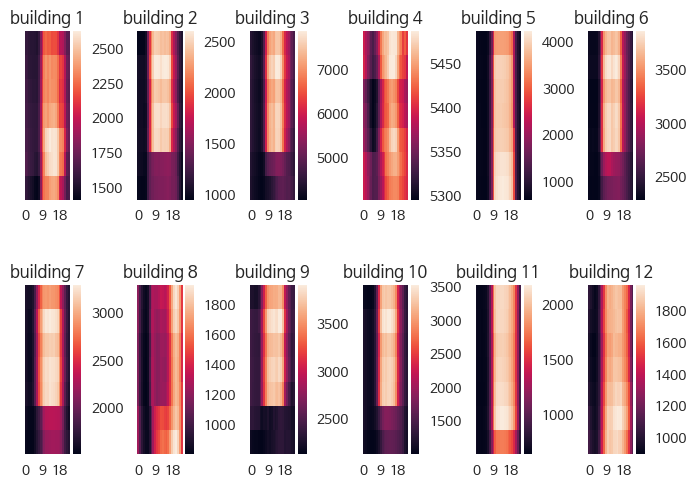

In [ ]:
# energy usage of each building ~ weekday, hour
#fig = plt.figure(figsize = (15, 40))
plt.subplots_adjust(hspace=0.5, wspace=1)  # 간격 조절
for num in combined_df['건물유형_라벨'].unique():
    df = combined_df[combined_df['건물유형_라벨'] == num]
    df = df.groupby(['요일', '시간'])['전력소비량(kWh)'].mean().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(2, 6, num)
    plt.rc('font', family='NanumBarunGothic')
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

건물번호 별 전력소비량 그래프

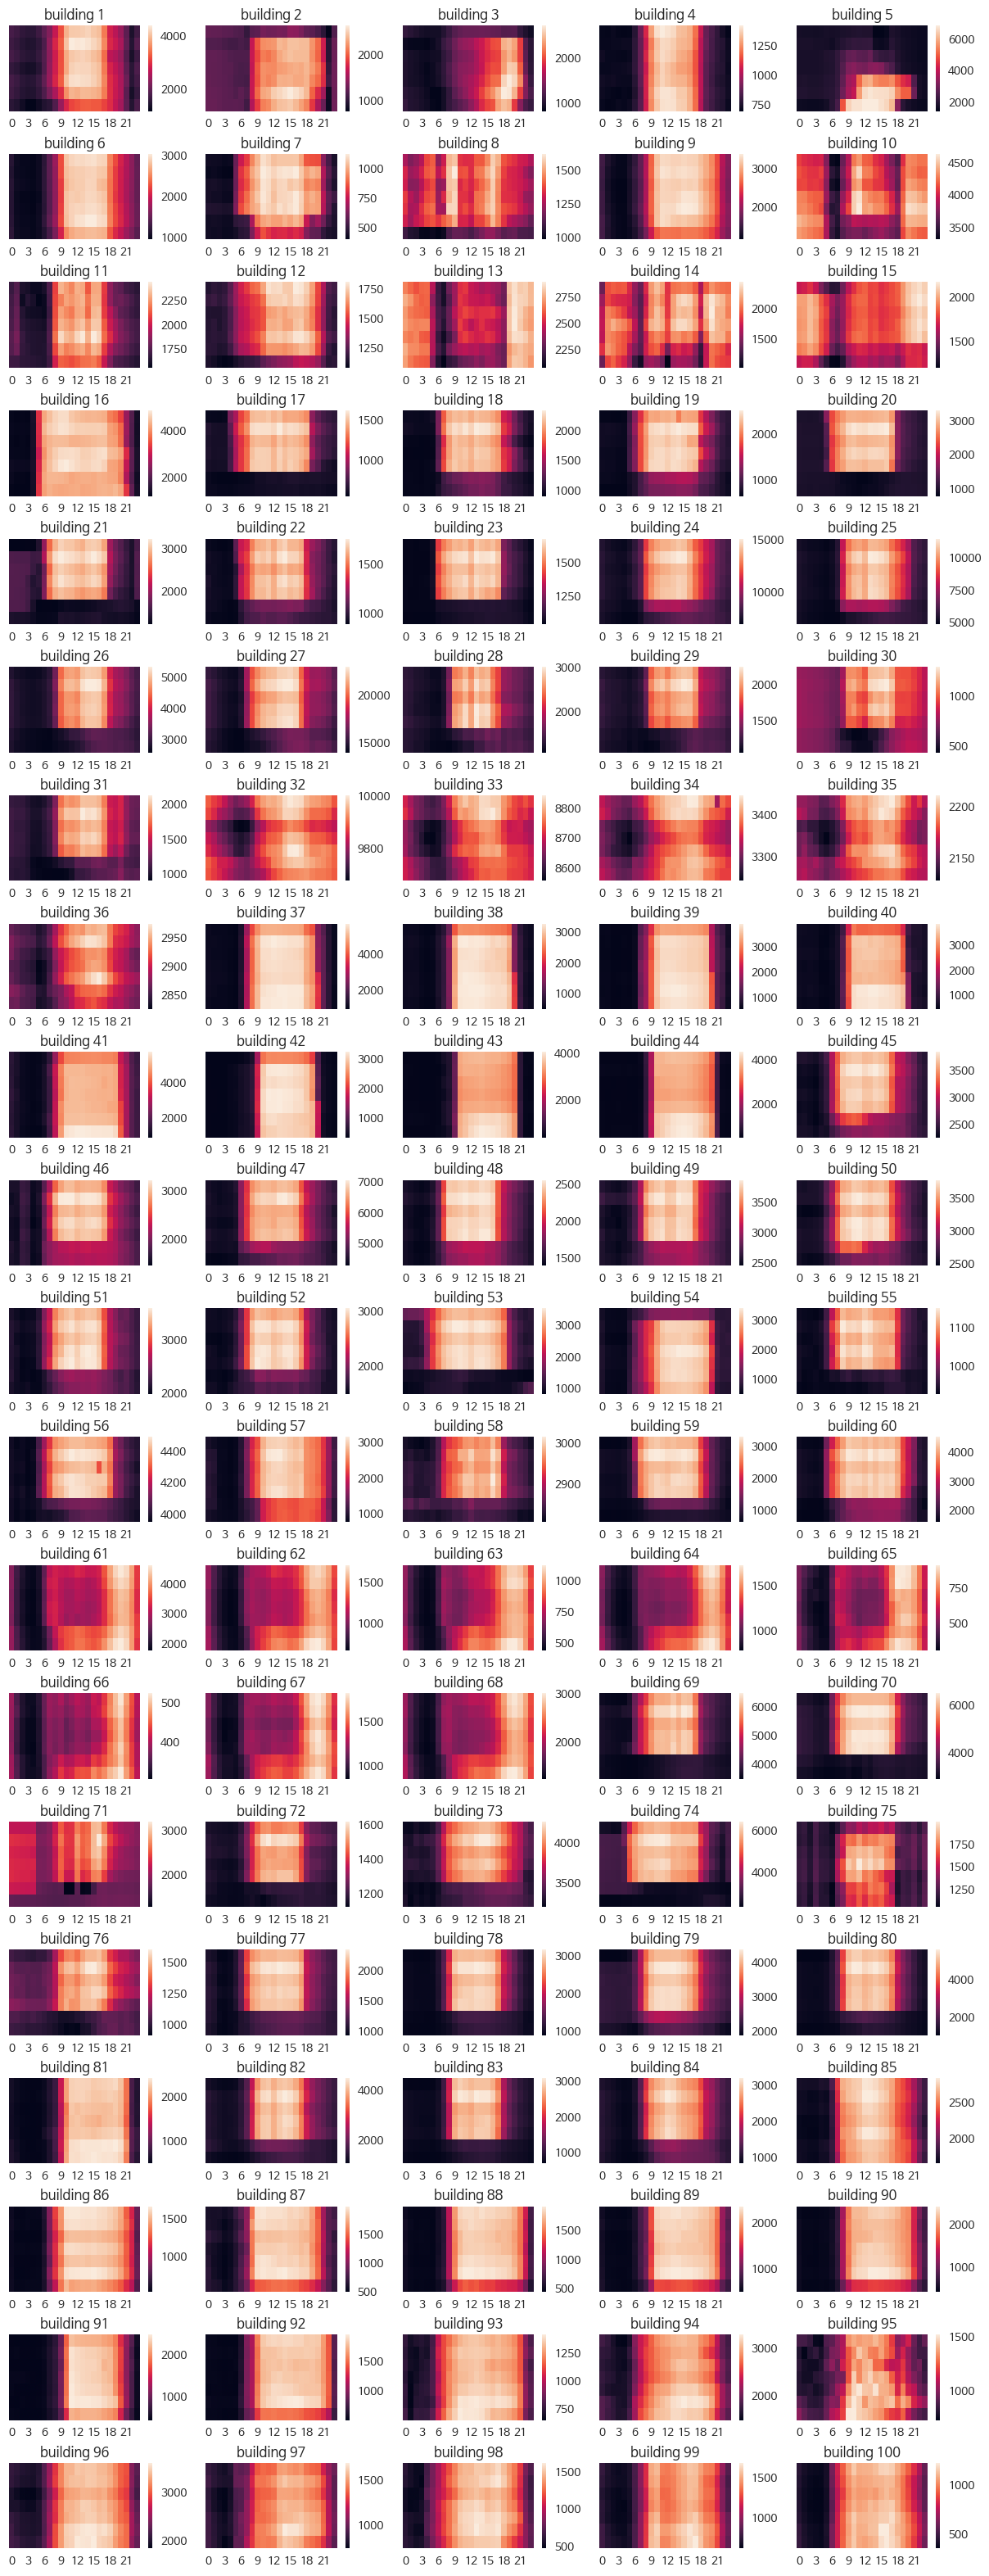

In [ ]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
plt.subplots_adjust(hspace=0.5)  # 간격 조절
for num in combined_df['건물번호'].unique():
    df = combined_df[combined_df['건물번호'] == num]
    df = df.groupby(['요일', '시간'])['전력소비량(kWh)'].mean().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(20, 5, num)
    plt.rc('font', family='NanumBarunGothic')
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [ ]:
combined_df.columns.tolist()

### 군집화 수행

요일별 시간별 데이터프레임 생성

In [16]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = combined_df.groupby(['건물유형_라벨','요일'])['전력소비량(kWh)'].median().reset_index().pivot('건물유형_라벨','요일','전력소비량(kWh)').reset_index()
by_hour = combined_df.groupby(['건물유형_라벨','시간'])['전력소비량(kWh)'].median().reset_index().pivot('건물유형_라벨','시간','전력소비량(kWh)').reset_index().drop('건물유형_라벨', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['건물유형_라벨'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [17]:
by_weekday

요일,건물유형_라벨,0,1,2,3,4,5,6
0,1,1631.34,1779.615,1774.035,1800.120,1827.36,1744.335,1603.92
1,2,1469.76,1610.760,1516.320,1560.385,1519.92,1062.900,1047.33
2,3,2736.96,2812.860,2765.280,2790.960,2791.02,2049.600,2118.84
3,4,3409.56,3404.160,3369.600,3325.320,3336.03,3370.500,3388.32
4,5,1356.00,2067.300,2035.140,2030.160,2084.07,2119.200,2106.30
5,6,2778.48,2837.340,2764.920,2804.040,2805.96,2442.240,2405.22
6,7,2329.50,2821.500,2767.200,2813.280,2809.74,1589.040,1580.40
7,8,1077.12,1068.930,1024.560,1017.000,1035.09,1079.160,1117.44
8,9,2560.44,2796.720,2719.560,2795.520,2651.94,2295.360,1917.00
9,10,1848.24,2115.120,1946.820,2040.480,2048.31,1268.400,1194.96


In [18]:
by_hour

시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1376.88,1315.440,1281.60,1283.28,1316.40,1351.20,1393.9200,1458.00,1715.760,1942.08,...,2146.56,2217.60,2204.16,2099.520,1956.96,1957.68,1926.000,1797.60,1566.720,1526.88
1,974.16,961.920,959.85,961.47,967.92,1034.25,1339.2000,1538.01,1701.000,1765.98,...,1774.26,1745.10,1763.01,1712.850,1446.75,1263.36,1182.000,1103.40,1043.310,999.15
2,2093.64,2040.480,1993.92,1967.34,1946.94,1916.88,1879.9800,1911.18,2126.760,2845.98,...,3101.76,3113.94,2974.68,2914.920,2693.52,2607.30,2501.580,2386.56,2248.620,2195.28
3,3334.68,3318.840,3303.72,3299.76,3286.80,3284.64,3307.3200,3318.12,3341.520,3369.60,...,3436.56,3440.88,3452.40,3456.000,3431.88,3414.24,3397.680,3381.84,3369.600,3355.92
4,568.26,565.140,553.80,538.02,519.69,527.04,604.2600,778.23,1307.850,2709.84,...,3744.00,3708.48,3670.11,3643.440,3585.84,3429.63,2537.100,1032.57,660.000,589.47
5,2199.69,2137.680,2114.46,2123.04,2104.02,2178.90,2476.9800,2777.88,3107.760,3233.46,...,3245.40,3256.35,3237.12,3027.720,2715.24,2610.00,2489.490,2452.08,2367.180,2269.86
6,975.48,945.540,935.82,939.96,956.52,1164.78,1720.4400,2397.42,2712.960,2792.88,...,3037.44,3018.48,3031.92,3000.720,2814.66,2541.60,2163.600,1592.64,1389.420,1099.86
7,1013.67,853.380,765.63,718.20,722.28,735.93,832.9500,991.71,1056.870,1065.12,...,1102.86,1121.67,1187.31,1283.805,1400.40,1492.50,1531.485,1482.12,1395.270,1217.52
8,2413.44,2391.960,2379.60,2373.84,2389.32,2069.28,2106.5275,2195.16,2468.520,2738.52,...,2718.12,2928.12,2955.48,2756.640,2485.56,2388.24,2357.640,2260.65,2151.360,2076.84
9,1058.88,1020.420,976.56,956.34,955.98,976.86,1091.2800,1414.08,2073.420,2395.26,...,2617.56,2594.94,2553.84,2456.100,2097.72,1879.20,1629.960,1412.64,1195.560,1126.80


In [19]:
df

,건물유형_라벨,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,1,1631.34,1779.615,1774.035,1800.120,1827.36,1744.335,1603.92,1376.88,1315.440,...,2146.56,2217.60,2204.16,2099.520,1956.96,1957.68,1926.000,1797.60,1566.720,1526.88
1,2,1469.76,1610.760,1516.320,1560.385,1519.92,1062.900,1047.33,974.16,961.920,...,1774.26,1745.10,1763.01,1712.850,1446.75,1263.36,1182.000,1103.40,1043.310,999.15
2,3,2736.96,2812.860,2765.280,2790.960,2791.02,2049.600,2118.84,2093.64,2040.480,...,3101.76,3113.94,2974.68,2914.920,2693.52,2607.30,2501.580,2386.56,2248.620,2195.28
3,4,3409.56,3404.160,3369.600,3325.320,3336.03,3370.500,3388.32,3334.68,3318.840,...,3436.56,3440.88,3452.40,3456.000,3431.88,3414.24,3397.680,3381.84,3369.600,3355.92
4,5,1356.00,2067.300,2035.140,2030.160,2084.07,2119.200,2106.30,568.26,565.140,...,3744.00,3708.48,3670.11,3643.440,3585.84,3429.63,2537.100,1032.57,660.000,589.47
5,6,2778.48,2837.340,2764.920,2804.040,2805.96,2442.240,2405.22,2199.69,2137.680,...,3245.40,3256.35,3237.12,3027.720,2715.24,2610.00,2489.490,2452.08,2367.180,2269.86
6,7,2329.50,2821.500,2767.200,2813.280,2809.74,1589.040,1580.40,975.48,945.540,...,3037.44,3018.48,3031.92,3000.720,2814.66,2541.60,2163.600,1592.64,1389.420,1099.86
7,8,1077.12,1068.930,1024.560,1017.000,1035.09,1079.160,1117.44,1013.67,853.380,...,1102.86,1121.67,1187.31,1283.805,1400.40,1492.50,1531.485,1482.12,1395.270,1217.52
8,9,2560.44,2796.720,2719.560,2795.520,2651.94,2295.360,1917.00,2413.44,2391.960,...,2718.12,2928.12,2955.48,2756.640,2485.56,2388.24,2357.640,2260.65,2151.360,2076.84
9,10,1848.24,2115.120,1946.820,2040.480,2048.31,1268.400,1194.96,1058.88,1020.420,...,2617.56,2594.94,2553.84,2456.100,2097.72,1879.20,1629.960,1412.64,1195.560,1126.80


표준화

In [20]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling' x >  표준화
# 평균 0, 표준편차 1로 조정
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

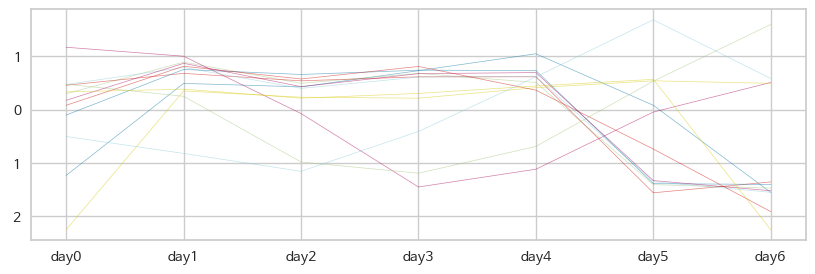

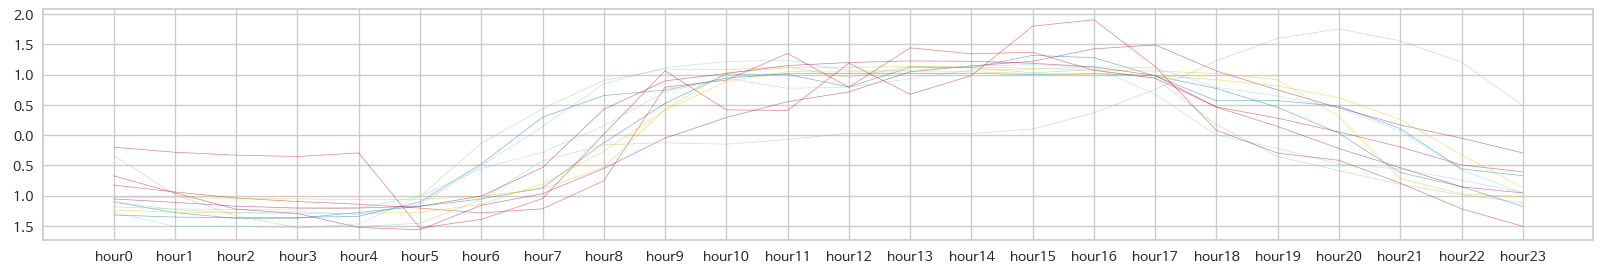

In [21]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

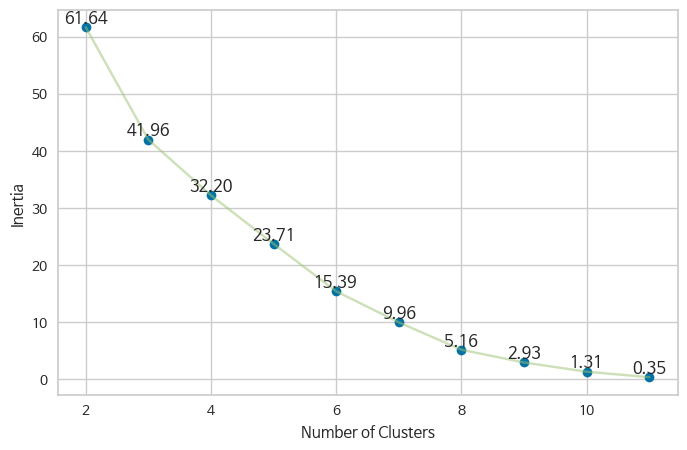

In [22]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

    for i, (x, y) in enumerate(zip(n_clusters, sum_of_squared_distance)):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

    return sum_of_squared_distance

# 군집화할 데이터 프레임인 df와 적절한 클러스터 개수를 지정하여 함수 호출
ssd = change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])


In [23]:
ssd # 클러스터 개수에 따른 응집도 결과 list

[61.64462112722737,
 41.963364050423316,
 32.20452878348388,
 23.706614967777938,
 15.387138069866463,
 9.958356414882081,
 5.155042461109344,
 2.9280637113052013,
 1.3121056110171179,
 0.3459768050811023]

In [24]:
# 클러스터 개수 4개로 지정
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

df_clust

,건물유형_라벨,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23,km_cluster
0,1,-1.233022,0.493279,0.428313,0.732009,1.049152,0.082529,-1.552261,-1.104439,-1.281583,...,1.319526,1.280776,0.979078,0.568049,0.570124,0.478785,0.108581,-0.557092,-0.671959,0
1,2,0.300225,0.891752,0.495555,0.680418,0.510658,-1.406645,-1.471964,-1.186759,-1.221977,...,1.031397,1.082928,0.938607,0.172981,-0.354670,-0.588760,-0.814909,-0.987800,-1.114858,3
2,3,0.458466,0.681282,0.541603,0.616991,0.617167,-1.559387,-1.356122,-0.826603,-0.941101,...,1.370965,1.071021,0.942307,0.465446,0.279741,0.052037,-0.195698,-0.492800,-0.607686,0
3,4,1.171441,1.003349,-0.072440,-1.450794,-1.117411,-0.044424,0.510279,-0.673172,-0.955824,...,1.221880,1.427445,1.491684,1.061283,0.746511,0.451012,0.168360,-0.050053,-0.294161,2
4,5,-2.250863,0.351745,0.234073,0.215852,0.413105,0.541644,0.494444,-1.034374,-1.036499,...,1.104460,1.078326,1.060161,1.020929,0.914533,0.306622,-0.718128,-0.971889,-1.019928,1
5,6,0.473407,0.792559,0.399882,0.611999,0.622410,-1.349763,-1.550494,-1.102422,-1.235610,...,1.167131,1.125828,0.676067,0.004905,-0.221135,-0.479973,-0.560324,-0.742677,-0.951707,3
6,7,-0.100396,0.755113,0.660694,0.740820,0.734664,-1.387936,-1.402960,-1.321732,-1.355785,...,1.001900,1.017186,0.981701,0.770083,0.459514,0.029591,-0.619797,-0.850932,-1.180267,3
7,8,0.478680,0.251015,-0.982379,-1.192531,-0.689667,0.535388,1.599493,-0.334857,-0.982607,...,0.101583,0.366842,0.756789,1.227963,1.600150,1.757692,1.558203,1.207232,0.488924,2
8,9,0.082628,0.815246,0.576001,0.811525,0.366336,-0.739289,-1.912445,-0.199844,-0.283374,...,1.801602,1.907998,1.134765,0.080610,-0.297840,-0.416835,-0.794002,-1.219000,-1.508787,0
9,10,0.176453,0.869926,0.432608,0.675978,0.696324,-1.330229,-1.521059,-1.055862,-1.112053,...,1.188362,1.128314,0.985514,0.461911,0.142647,-0.221499,-0.539009,-0.856169,-0.956629,3


In [25]:
df_clust.columns.tolist()

['건물유형_라벨',
 'day0',
 'day1',
 'day2',
 'day3',
 'day4',
 'day5',
 'day6',
 'hour0',
 'hour1',
 'hour2',
 'hour3',
 'hour4',
 'hour5',
 'hour6',
 'hour7',
 'hour8',
 'hour9',
 'hour10',
 'hour11',
 'hour12',
 'hour13',
 'hour14',
 'hour15',
 'hour16',
 'hour17',
 'hour18',
 'hour19',
 'hour20',
 'hour21',
 'hour22',
 'hour23',
 'km_cluster']

요일별 시간별 전력소비량 그래프 (왼:요일, 오:시간)

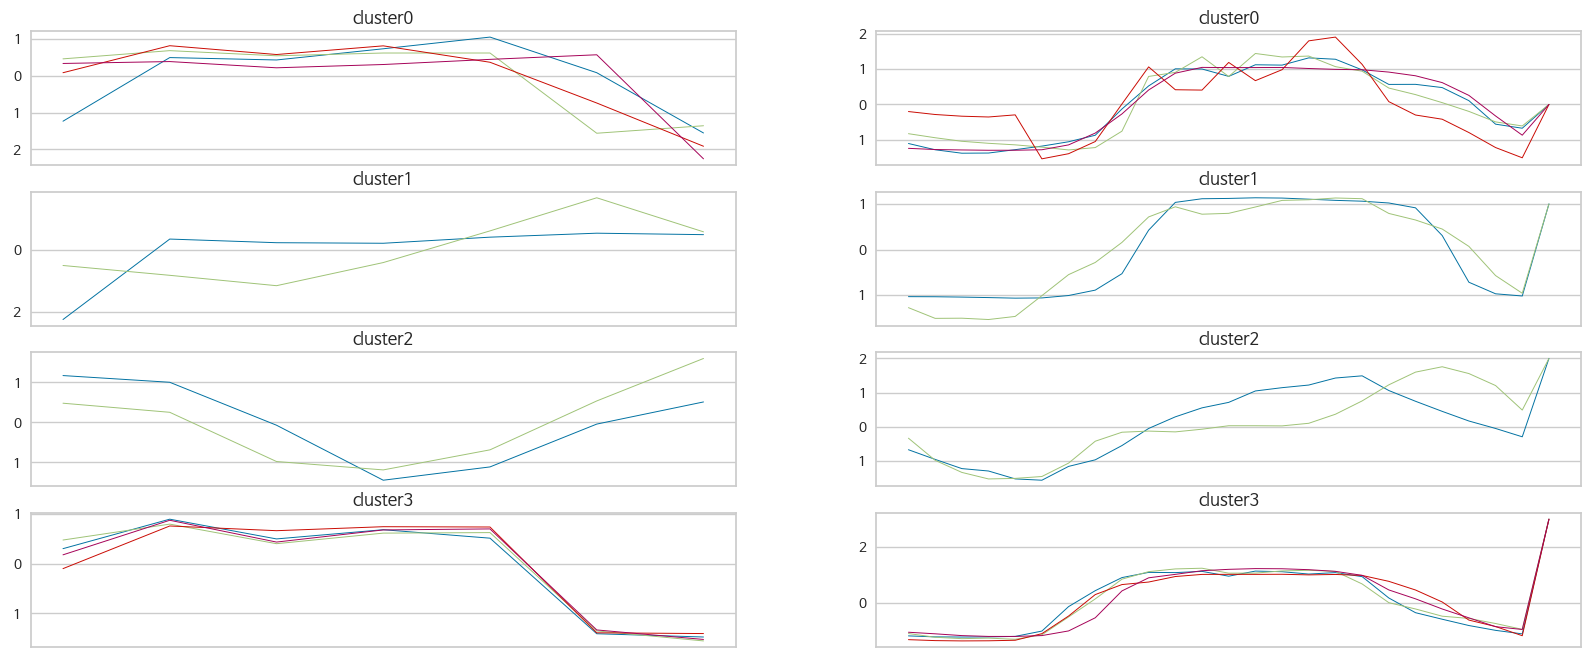

In [26]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster))

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)): # 요일별
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)): # 시간대별
        plt.plot(temp.iloc[i,8:], linewidth=0.7) # temp.iloc[i,8:-6]
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [27]:
combined_clust_df = combined_df.merge(df_clust[['건물유형_라벨','km_cluster']], on = '건물유형_라벨', how = 'left')
combined_clust_df

,건물번호,일시,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,...,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,km_cluster
0,1,2022-06-01 00:00:00,0.9,42.0,1085.28,0.314815,63.09388,True,6,1,...,0,0,0,0,0,0,0,1,False,0
1,1,2022-06-01 01:00:00,1.1,45.0,1047.36,0.292593,62.46400,True,6,1,...,0,0,0,0,0,0,0,1,False,0
2,1,2022-06-01 02:00:00,1.5,45.0,974.88,0.281481,62.08735,True,6,1,...,0,0,0,0,0,0,0,1,False,0
3,1,2022-06-01 03:00:00,1.4,48.0,953.76,0.244444,60.89884,True,6,1,...,0,0,0,0,0,0,0,1,False,0
4,1,2022-06-01 04:00:00,2.8,43.0,986.40,0.307407,62.88788,True,6,1,...,0,0,0,0,0,0,0,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,0.9,86.0,881.04,0.481481,72.38034,False,8,24,...,0,0,0,0,0,0,1,12,False,1
203996,100,2022-08-24 20:00:00,1.3,86.0,798.96,0.455556,71.21736,False,8,24,...,0,0,0,0,0,0,1,12,False,1
203997,100,2022-08-24 21:00:00,1.0,92.0,825.12,0.414815,69.79704,False,8,24,...,0,0,0,0,0,0,1,12,False,1
203998,100,2022-08-24 22:00:00,0.3,94.0,640.08,0.403704,69.41060,False,8,24,...,0,0,0,0,0,0,1,12,False,1


In [28]:
combined_clust_df

,건물번호,일시,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,...,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,km_cluster
0,1,2022-06-01 00:00:00,0.9,42.0,1085.28,0.314815,63.09388,True,6,1,...,0,0,0,0,0,0,0,1,False,0
1,1,2022-06-01 01:00:00,1.1,45.0,1047.36,0.292593,62.46400,True,6,1,...,0,0,0,0,0,0,0,1,False,0
2,1,2022-06-01 02:00:00,1.5,45.0,974.88,0.281481,62.08735,True,6,1,...,0,0,0,0,0,0,0,1,False,0
3,1,2022-06-01 03:00:00,1.4,48.0,953.76,0.244444,60.89884,True,6,1,...,0,0,0,0,0,0,0,1,False,0
4,1,2022-06-01 04:00:00,2.8,43.0,986.40,0.307407,62.88788,True,6,1,...,0,0,0,0,0,0,0,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,0.9,86.0,881.04,0.481481,72.38034,False,8,24,...,0,0,0,0,0,0,1,12,False,1
203996,100,2022-08-24 20:00:00,1.3,86.0,798.96,0.455556,71.21736,False,8,24,...,0,0,0,0,0,0,1,12,False,1
203997,100,2022-08-24 21:00:00,1.0,92.0,825.12,0.414815,69.79704,False,8,24,...,0,0,0,0,0,0,1,12,False,1
203998,100,2022-08-24 22:00:00,0.3,94.0,640.08,0.403704,69.41060,False,8,24,...,0,0,0,0,0,0,1,12,False,1


클러스터별 건물유형 출력

In [29]:
for cluster_num in range(4):
    buildings_in_cluster = combined_clust_df[combined_clust_df['km_cluster'] == cluster_num]['건물유형_라벨'].unique()
    print(f'Cluster {cluster_num}: {buildings_in_cluster}')

Cluster 0: [ 1  3  9 11]
Cluster 1: [ 5 12]
Cluster 2: [4 8]
Cluster 3: [ 2  6  7 10]


In [30]:
for cluster_num in range(4):
    buildings_in_cluster = combined_clust_df[combined_clust_df['km_cluster'] == cluster_num]['건물유형_라벨'].unique()
    arr = list()
    for df in buildings_in_cluster:
      btype = binfo_df[binfo_df['건물유형_라벨'] == df]['건물유형'].values[0]
      arr.append(btype)
    print(f'Cluster {cluster_num}: {arr}')

Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']
Cluster 1: ['백화점및아울렛', '호텔및리조트']
Cluster 2: ['데이터센터', '아파트']
Cluster 3: ['공공', '병원', '상용', '지식산업센터']


클러스터별 전력소비량 그래프

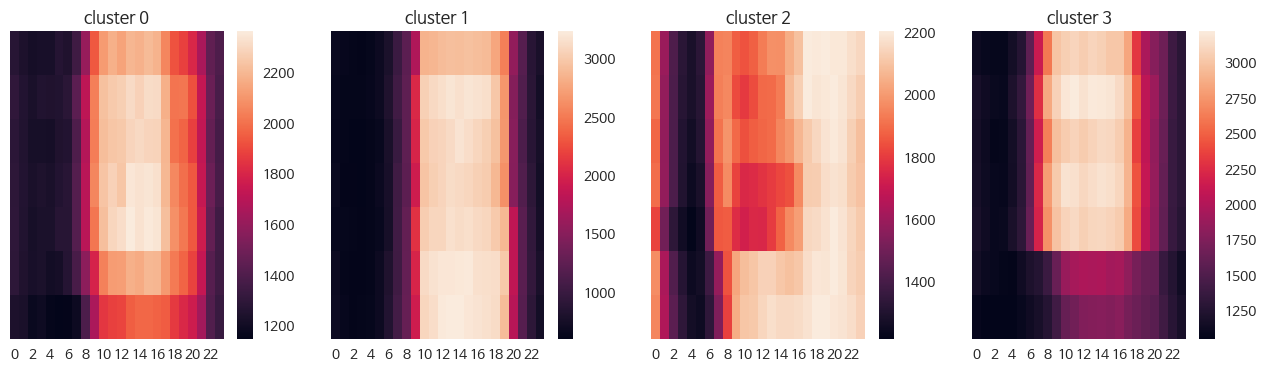

In [31]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = combined_clust_df[combined_clust_df.km_cluster == c]
    temp = temp.groupby(['요일', '시간'])['전력소비량(kWh)'].median().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [32]:
# dictionary mapping cluster and building
match = df_clust[['건물유형_라벨','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(12):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

In [33]:
clust_to_num

{0: [1, 3, 9, 11], 1: [5, 12], 2: [4, 8], 3: [2, 6, 7, 10]}

In [34]:
combined_clust_df['datetime'] = pd.to_datetime('2022-' + combined_clust_df['월'].astype(str) + '-' + combined_clust_df['일'].astype(str))
combined_clust_df

,건물번호,일시,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,...,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,km_cluster,datetime
0,1,2022-06-01 00:00:00,0.9,42.0,1085.28,0.314815,63.09388,True,6,1,...,0,0,0,0,0,0,1,False,0,2022-06-01
1,1,2022-06-01 01:00:00,1.1,45.0,1047.36,0.292593,62.46400,True,6,1,...,0,0,0,0,0,0,1,False,0,2022-06-01
2,1,2022-06-01 02:00:00,1.5,45.0,974.88,0.281481,62.08735,True,6,1,...,0,0,0,0,0,0,1,False,0,2022-06-01
3,1,2022-06-01 03:00:00,1.4,48.0,953.76,0.244444,60.89884,True,6,1,...,0,0,0,0,0,0,1,False,0,2022-06-01
4,1,2022-06-01 04:00:00,2.8,43.0,986.40,0.307407,62.88788,True,6,1,...,0,0,0,0,0,0,1,False,0,2022-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,0.9,86.0,881.04,0.481481,72.38034,False,8,24,...,0,0,0,0,0,1,12,False,1,2022-08-24
203996,100,2022-08-24 20:00:00,1.3,86.0,798.96,0.455556,71.21736,False,8,24,...,0,0,0,0,0,1,12,False,1,2022-08-24
203997,100,2022-08-24 21:00:00,1.0,92.0,825.12,0.414815,69.79704,False,8,24,...,0,0,0,0,0,1,12,False,1,2022-08-24
203998,100,2022-08-24 22:00:00,0.3,94.0,640.08,0.403704,69.41060,False,8,24,...,0,0,0,0,0,1,12,False,1,2022-08-24


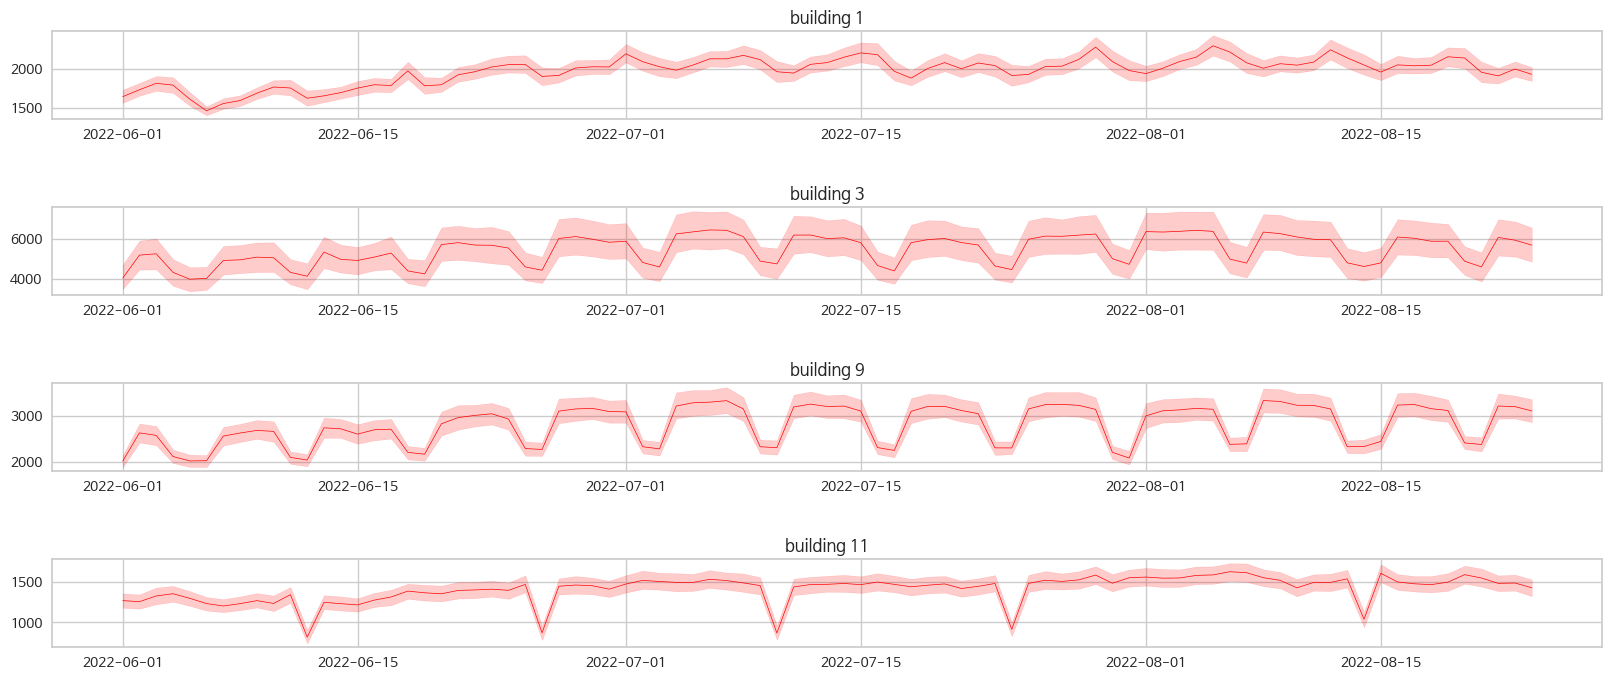

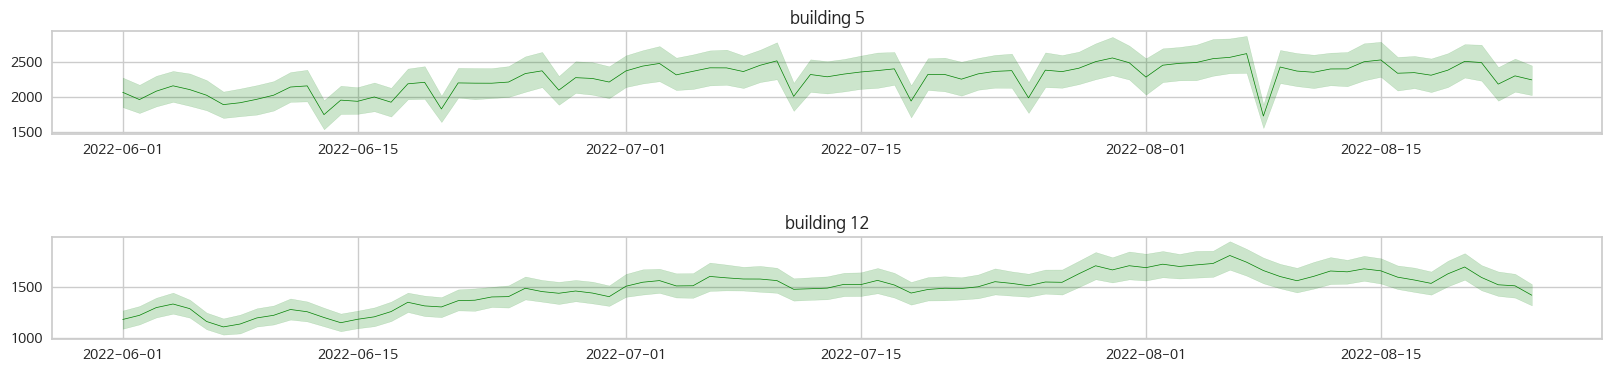

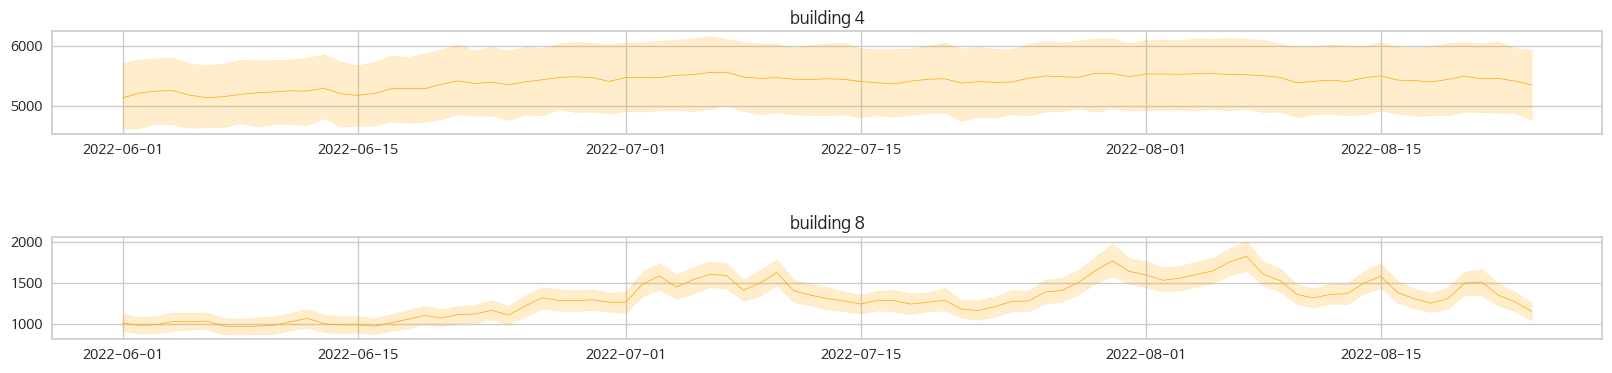

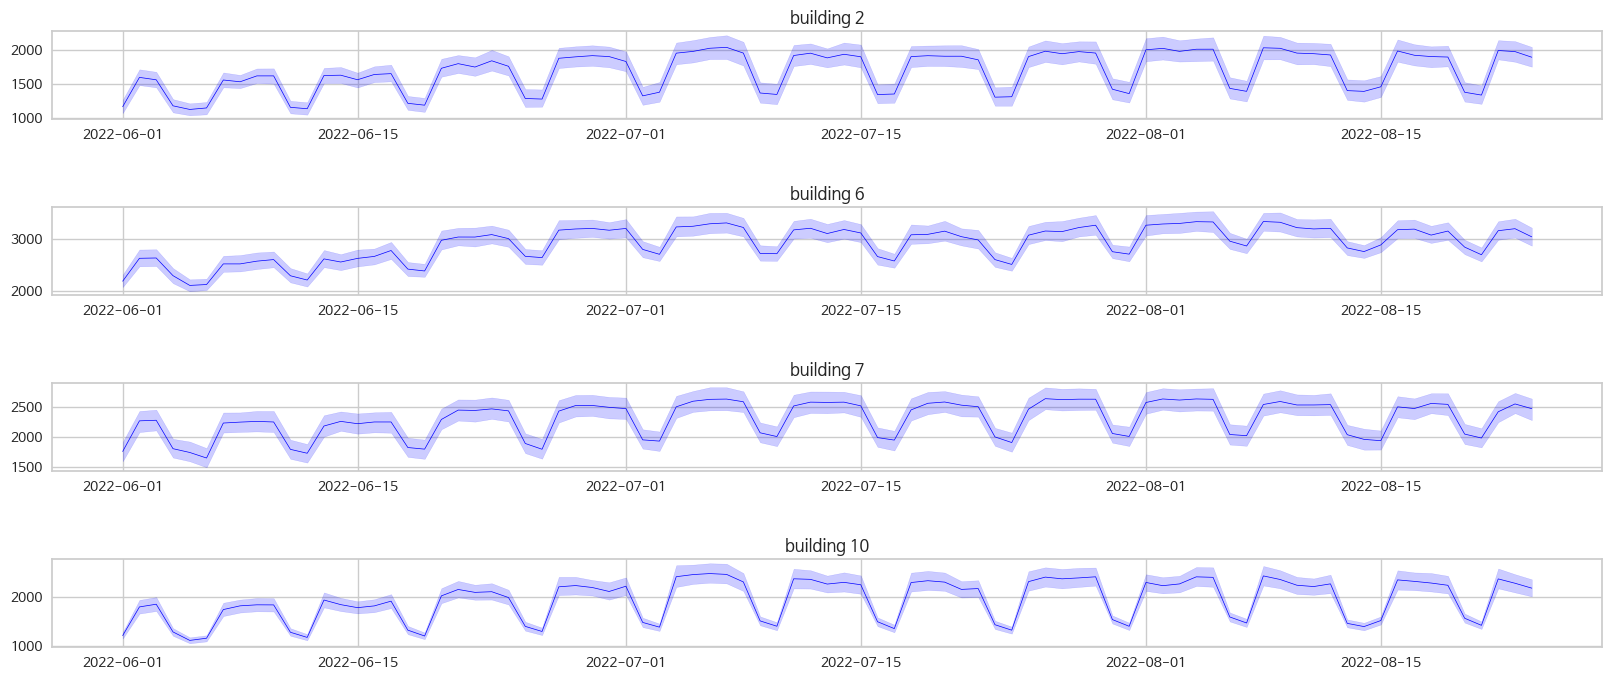

In [35]:
# linplot(energy usage of each building ~ cluster, datetime)
for c, col in enumerate(['red','green','orange','blue']):
    temp_1 = combined_clust_df[combined_clust_df.km_cluster == c]
    nums = np.unique(temp_1['건물유형_라벨'])
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 2*n_nums))
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1['건물유형_라벨'] == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = '전력소비량(kWh)', linewidth = 0.5, color = col)
        plt.title(f'building {num}')
        plt.subplots_adjust(hspace = 1)
        plt.ylabel('')
        plt.xlabel('')

### 각 군집별로 모델 생성(best model)

In [53]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'km_cluster',
 'datetime']

In [ ]:
selected_columns = ['건물번호',
 'km_cluster',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)']
combined_clust_train_df = combined_clust_df[selected_columns]

cluster_data = []
for cluster_id in range(4):
    cluster_data.append(combined_clust_train_df[combined_clust_train_df['km_cluster'] == cluster_id].reset_index(drop=True))

cluster_data

In [ ]:
cluster_data[1]

,건물번호,km_cluster,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh)
0,37,1,0.9,42.0,947.40,0.314815,63.09388,False,6,1,0,98528.77,75517.52,35.0,0.0
1,37,1,1.1,45.0,890.40,0.292593,62.46400,False,6,1,1,98528.77,75517.52,35.0,0.0
2,37,1,1.5,45.0,885.60,0.281481,62.08735,False,6,1,2,98528.77,75517.52,35.0,0.0
3,37,1,1.4,48.0,880.20,0.244444,60.89884,False,6,1,3,98528.77,75517.52,35.0,0.0
4,37,1,2.8,43.0,888.00,0.307407,62.88788,False,6,1,4,98528.77,75517.52,35.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32635,100,1,0.9,86.0,881.04,0.481481,72.38034,False,8,24,19,57497.84,40035.23,0.0,0.0
32636,100,1,1.3,86.0,798.96,0.455556,71.21736,False,8,24,20,57497.84,40035.23,0.0,0.0
32637,100,1,1.0,92.0,825.12,0.414815,69.79704,False,8,24,21,57497.84,40035.23,0.0,0.0
32638,100,1,0.3,94.0,640.08,0.403704,69.41060,False,8,24,22,57497.84,40035.23,0.0,0.0


In [54]:
cluster_data[1].columns.tolist()

['건물번호',
 'km_cluster',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

In [41]:
for i in tqdm(range(len(cluster_data))):

  # pycaret 설정
  exp1 = setup(data=cluster_data[i], target='전력소비량(kWh)', ignore_features=['건물번호','km_cluster'])

  # 모델 학습 및 비교
  best_model = compare_models()

  # 결과 출력
  print(best_model)

  # 모델 생성
  clust_model = create_model(best_model)

  # 모델 저장
  save_model(clust_model, 'model_clust_noOneHot'+ str(i))

  0%|          | 0/4 [00:00<?, ?it/s]

,Description,Value
0,Session id,4894
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 15)"
4,Transformed data shape,"(79560, 13)"
5,Transformed train set shape,"(55692, 13)"
6,Transformed test set shape,"(23868, 13)"
7,Ignore features,2
8,Numeric features,11
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,112.9050,48859.3451,220.8912,0.9951,0.1039,0.0572,20.6770
rf,Random Forest Regressor,117.1673,52708.5225,229.4074,0.9947,0.1038,0.0581,35.7150
xgboost,Extreme Gradient Boosting,171.3182,80210.7328,283.1279,0.9919,0.1410,0.0928,6.2440
dt,Decision Tree Regressor,145.9262,95213.6635,307.9263,0.9904,0.1363,0.0700,0.6390
lightgbm,Light Gradient Boosting Machine,204.3677,102032.8865,319.3845,0.9897,0.1650,0.1167,1.2160
gbr,Gradient Boosting Regressor,414.5361,357217.0122,597.6238,0.9640,0.2844,0.2369,7.7690
knn,K Neighbors Regressor,294.4852,358535.4656,598.3501,0.9639,0.1881,0.1266,0.9930
ada,AdaBoost Regressor,1119.4540,1911764.5372,1382.5963,0.8074,0.6391,0.7727,3.8680
lar,Least Angle Regression,1223.5396,3055634.9750,1747.9454,0.6923,0.7682,0.6525,0.1660
ridge,Ridge Regression,1223.1239,3055626.5750,1747.9422,0.6923,0.7663,0.6519,0.3400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=4894)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,113.0404,49405.1104,222.2726,0.9949,0.1049,0.0585
1,113.1771,49607.7271,222.7279,0.9950,0.1004,0.0557
2,111.3157,49604.2344,222.7201,0.9952,0.1027,0.0559
3,113.6689,47016.6800,216.8333,0.9951,0.1029,0.0577
4,111.1888,49384.4831,222.2262,0.9949,0.1032,0.0559
5,118.2746,54289.7116,233.0015,0.9947,0.1072,0.0589
6,113.9360,52482.4816,229.0906,0.9947,0.1061,0.0582
7,109.9460,41588.5451,203.9327,0.9960,0.1042,0.0571
8,113.8308,50980.0106,225.7875,0.9948,0.1070,0.0585


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [15:07<45:23, 907.82s/it]

Transformation Pipeline and Model Successfully Saved


,Description,Value
0,Session id,1477
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(32640, 15)"
4,Transformed data shape,"(32640, 13)"
5,Transformed train set shape,"(22848, 13)"
6,Transformed test set shape,"(9792, 13)"
7,Ignore features,2
8,Numeric features,11
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,89.8426,34706.4858,185.7962,0.9814,0.1191,0.0634,7.4560
rf,Random Forest Regressor,91.6039,35725.4682,188.5607,0.9809,0.1206,0.0643,12.1280
xgboost,Extreme Gradient Boosting,111.5940,38151.8857,194.9837,0.9796,0.1533,0.0824,2.2720
lightgbm,Light Gradient Boosting Machine,120.9785,42764.6891,206.4724,0.9771,0.1437,0.0897,0.5060
dt,Decision Tree Regressor,115.2957,64336.3589,253.1419,0.9656,0.1585,0.0794,0.2370
gbr,Gradient Boosting Regressor,248.6627,132726.2783,364.1527,0.9291,0.2788,0.1906,2.9840
knn,K Neighbors Regressor,229.9845,175742.1281,418.9769,0.9061,0.2490,0.1650,0.1780
ada,AdaBoost Regressor,735.0802,660080.7095,812.2141,0.6472,0.5874,0.6938,1.6870
lr,Linear Regression,843.6804,1137927.8250,1066.5972,0.3920,0.6882,0.6917,0.1020
lar,Least Angle Regression,843.8286,1138057.4000,1066.6579,0.3919,0.6880,0.6915,0.1450


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=1477)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,95.9546,41413.6657,203.5035,0.9788,0.1199,0.0675
1,83.6658,26059.0950,161.4283,0.9862,0.1068,0.0611
2,90.2917,32774.4895,181.0373,0.9830,0.1826,0.0613
3,87.5773,30789.8059,175.4702,0.9834,0.1005,0.0592
4,89.6986,36019.7090,189.7886,0.9807,0.1230,0.0674
5,91.2934,30956.3307,175.9441,0.9833,0.1108,0.0633
6,90.3027,34221.1312,184.9895,0.9815,0.1118,0.0636
7,90.9806,41446.4544,203.5840,0.9780,0.1153,0.0645
8,91.5567,41671.0839,204.1350,0.9768,0.1185,0.0655


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [20:34<18:52, 566.23s/it]

Transformation Pipeline and Model Successfully Saved


,Description,Value
0,Session id,266
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(26520, 15)"
4,Transformed data shape,"(26520, 13)"
5,Transformed train set shape,"(18564, 13)"
6,Transformed test set shape,"(7956, 13)"
7,Ignore features,2
8,Numeric features,11
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:30:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,59.9415,13803.6714,117.1656,0.9984,0.0722,0.0403,0.3890
knn,K Neighbors Regressor,83.8904,22434.2273,149.3980,0.9974,0.0948,0.0594,0.3040
ridge,Ridge Regression,2236.7073,7731722.7000,2780.3845,0.0991,1.0908,1.6848,0.1510
lar,Least Angle Regression,2236.8605,7731724.4500,2780.3853,0.0991,1.0898,1.6841,0.0890
lr,Linear Regression,2236.6441,7735393.6500,2781.0427,0.0987,1.0884,1.6868,0.1020
lasso,Lasso Regression,2236.6803,7735540.5500,2781.0691,0.0987,1.0883,1.6871,0.2550
llar,Lasso Least Angle Regression,2236.6805,7735540.9000,2781.0692,0.0987,1.0883,1.6871,0.0940
en,Elastic Net,2237.2078,7735885.9500,2781.1300,0.0986,1.0884,1.6906,0.2900
br,Bayesian Ridge,2237.4321,7736780.1000,2781.2907,0.0985,1.0886,1.6928,0.0970
omp,Orthogonal Matching Pursuit,2209.4198,7990071.4500,2826.4678,0.0690,1.1196,1.7743,0.0930


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,37.2628,4658.0581,67.7931,0.9995,0.0442,0.0254,5.2400
xgboost,Extreme Gradient Boosting,41.4632,4512.9849,66.9159,0.9995,0.0510,0.0305,1.9440
lightgbm,Light Gradient Boosting Machine,46.8083,5345.2586,72.8905,0.9994,0.0566,0.0347,0.3630
rf,Random Forest Regressor,44.2264,6765.0526,81.8687,0.9992,0.0512,0.0299,8.8340
dt,Decision Tree Regressor,59.9415,13803.6714,117.1656,0.9984,0.0722,0.0403,0.3890
gbr,Gradient Boosting Regressor,89.3690,17624.5918,132.5738,0.9979,0.1175,0.0703,2.2140
knn,K Neighbors Regressor,83.8904,22434.2273,149.3980,0.9974,0.0948,0.0594,0.3040
ada,AdaBoost Regressor,358.2082,190737.0052,436.1696,0.9778,0.4539,0.4351,1.2790
lar,Least Angle Regression,2236.8605,7731724.4500,2780.3853,0.0991,1.0898,1.6841,0.0890
ridge,Ridge Regression,2236.7073,7731722.7000,2780.3845,0.0991,1.0908,1.6848,0.1510


ExtraTreesRegressor(n_jobs=-1, random_state=266)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,36.6746,4030.5930,63.4870,0.9995,0.0425,0.0255
1,41.3797,5825.7227,76.3264,0.9993,0.0508,0.0281
2,34.9454,3406.0415,58.3613,0.9996,0.0413,0.0244
3,37.1024,4275.3523,65.3862,0.9995,0.0417,0.0249
4,35.3436,4479.4309,66.9286,0.9995,0.0422,0.0242
5,35.5065,3989.0750,63.1591,0.9995,0.0403,0.0235
6,36.8078,4127.2210,64.2435,0.9995,0.0460,0.0268
7,37.0783,4147.5939,64.4018,0.9995,0.0411,0.0249
8,40.3661,7658.9327,87.5153,0.9991,0.0531,0.0270


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


 75%|███████▌  | 3/4 [24:42<07:00, 420.57s/it]

,Description,Value
0,Session id,5996
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(65280, 15)"
4,Transformed data shape,"(65280, 13)"
5,Transformed train set shape,"(45696, 13)"
6,Transformed test set shape,"(19584, 13)"
7,Ignore features,2
8,Numeric features,11
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,77.9939,18308.6079,135.2187,0.9884,0.0729,0.0416,24.4950
xgboost,Extreme Gradient Boosting,115.9359,29630.5439,172.0512,0.9812,0.1055,0.0667,4.3260
dt,Decision Tree Regressor,97.8374,32660.1551,180.6679,0.9792,0.0962,0.0509,0.4740
lightgbm,Light Gradient Boosting Machine,138.1336,38902.8689,197.1708,0.9752,0.1139,0.0799,0.8540
et,Extra Trees Regressor,143.1477,78475.5318,280.0300,0.9500,0.1237,0.0716,15.8770
gbr,Gradient Boosting Regressor,303.9623,168544.9255,410.5069,0.8927,0.2309,0.1840,5.7250
knn,K Neighbors Regressor,277.3917,206461.8797,454.2719,0.8687,0.2279,0.1571,0.6040
ada,AdaBoost Regressor,686.9073,622534.5752,788.9088,0.6037,0.4598,0.4837,3.2480
lar,Least Angle Regression,912.6161,1322169.1750,1149.7897,0.1588,0.5551,0.5736,0.1450
ridge,Ridge Regression,912.3835,1322205.8250,1149.8059,0.1588,0.5552,0.5736,0.1390


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

RandomForestRegressor(n_jobs=-1, random_state=5996)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,77.5995,19197.8176,138.5562,0.9879,0.0750,0.0420
1,79.9979,17920.3301,133.8668,0.9890,0.0751,0.0426
2,77.2442,19083.1389,138.1417,0.9876,0.0772,0.0425
3,78.0597,18214.8544,134.9624,0.9880,0.0723,0.0411
4,77.6862,17242.1409,131.3093,0.9890,0.0716,0.0419
5,76.6138,17475.5119,132.1950,0.9891,0.0715,0.0405
6,80.2091,21181.8497,145.5399,0.9867,0.0763,0.0427
7,77.6460,18427.3304,135.7473,0.9886,0.0702,0.0403
8,80.3865,18553.2351,136.2103,0.9879,0.0715,0.0421


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


100%|██████████| 4/4 [35:29<00:00, 532.26s/it]


In [58]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/test.csv')

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(df, binfo_df, on='건물번호', how='left')

selected_columns = ['건물유형_라벨',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
test_df_final = test_df[selected_columns]

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df_final

,건물유형_라벨,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,1,2.2,72,0.562189,71.78980,False,8,25,0,110634.00,...,0,0,0,0,0,0,0,0,0,0
1,1,0.9,72,0.537313,71.02840,False,8,25,1,110634.00,...,0,0,0,0,0,0,0,0,0,0
2,1,1.5,75,0.522388,70.81675,False,8,25,2,110634.00,...,0,0,0,0,0,0,0,0,0,0
3,1,1.3,78,0.492537,70.11262,False,8,25,3,110634.00,...,0,0,0,0,0,0,0,0,0,0
4,1,1.0,77,0.477612,69.56514,False,8,25,4,110634.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,12,0.9,84,0.512438,71.22400,False,8,31,19,57497.84,...,0,0,0,0,0,0,0,0,0,1
16796,12,0.4,95,0.422886,68.95035,False,8,31,20,57497.84,...,0,0,0,0,0,0,0,0,0,1
16797,12,0.4,98,0.398010,68.24604,False,8,31,21,57497.84,...,0,0,0,0,0,0,0,0,0,1
16798,12,1.1,97,0.393035,68.01203,False,8,31,22,57497.84,...,0,0,0,0,0,0,0,0,0,1


In [59]:
test_df_final.columns.tolist()

['건물유형_라벨',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

In [60]:
from pycaret.regression import *
from sklearn.metrics import mean_squared_error

# 모델들이 저장된 디렉토리 경로
model_directory = '/content/drive/MyDrive/Colab Notebooks/dacon/'

# 예측값을 저장할 컬럼
test_df_final['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():
    # 해당 클러스터의 모델 불러오기
    cluster_model = load_model(model_directory + 'model_clust' + str(cluster))

    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_final[test_df_final['건물유형_라벨'].isin(building_labels)]
    cluster_test_data = cluster_test_data.drop(columns=['건물유형_라벨', 'answer'])

    # 테스트 데이터로 예측 수행
    #final_model = finalize_model(cluster_model)
    predictions = predict_model(cluster_model, cluster_test_data)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df_final.loc[predictions.index, 'answer'] = predictions['prediction_label']

    # 변수 중요도 시각화
    #plot_model(final_model, plot='feature')


test_df_final

Transformation Pipeline and Model Successfully Loaded


ValueError: ignored

In [47]:
predictions

,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),prediction_label
2520,0.8,88,0.412935,68.180603,False,8,25,0,240038.000000,95175.000000,20.0,0.0,1277.205598
2521,0.5,89,0.402985,67.902328,False,8,25,1,240038.000000,95175.000000,20.0,0.0,1271.003999
2522,0.9,89,0.402985,67.902328,False,8,25,2,240038.000000,95175.000000,20.0,0.0,1260.554395
2523,0.1,93,0.378109,67.268860,False,8,25,3,240038.000000,95175.000000,20.0,0.0,1276.588807
2524,0.4,94,0.363184,66.799698,False,8,25,4,240038.000000,95175.000000,20.0,0.0,1485.633604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14107,1.1,84,0.507463,71.059837,False,8,31,19,174408.203125,109973.101562,0.0,0.0,1776.577207
14108,0.8,86,0.462687,69.722099,False,8,31,20,174408.203125,109973.101562,0.0,0.0,1538.515200
14109,0.9,86,0.477612,70.220520,False,8,31,21,174408.203125,109973.101562,0.0,0.0,1351.905593
14110,0.4,93,0.442786,69.518768,False,8,31,22,174408.203125,109973.101562,0.0,0.0,1212.998398


In [46]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = test_df_final['answer']
df.to_csv('submit_clust.csv', index=False)

In [51]:
# 데이터 불러오기
df = pd.read_csv('/content/submit_clust.csv')

df['answer'] = scaler.inverse_transform(df[['answer']])  #  역변환

df.to_csv('submit_clust_invers.csv', index=False)

df

,num_date_time,answer
0,1_20220825 00,20178.581522
1,1_20220825 01,19193.767366
2,1_20220825 02,18381.175290
3,1_20220825 03,17688.220282
4,1_20220825 04,20065.700074
...,...,...
16795,100_20220831 19,39947.749376
16796,100_20220831 20,38712.669395
16797,100_20220831 21,29469.686489
16798,100_20220831 22,26298.366536


### 각 군집별로 모델 생성(xbg)

In [75]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'km_cluster',
 'datetime']

In [ ]:
selected_columns = ['건물번호',
 'km_cluster',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
combined_clust_train_df = combined_clust_df[selected_columns]

cluster_data = []
for cluster_id in range(4):
    cluster_data.append(combined_clust_train_df[combined_clust_train_df['km_cluster'] == cluster_id].reset_index(drop=True))

cluster_data

In [79]:
cluster_data[1].columns.tolist()

['건물번호',
 'km_cluster',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

SMAPE: 9.62926


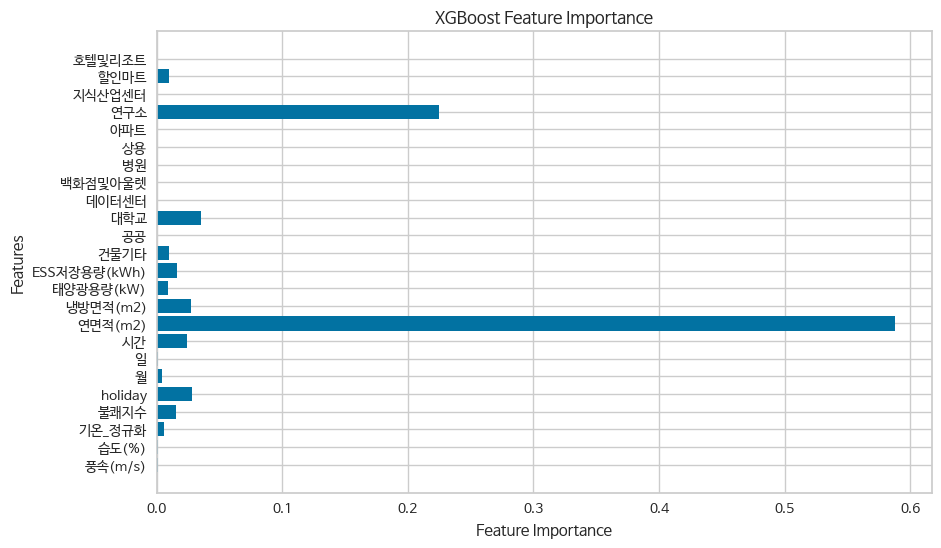

SMAPE: 7.56745


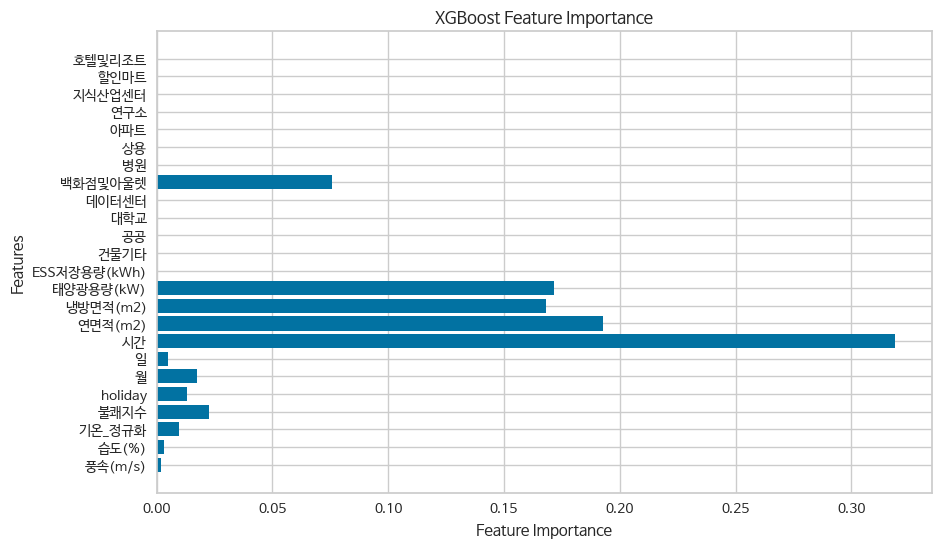

SMAPE: 3.28746


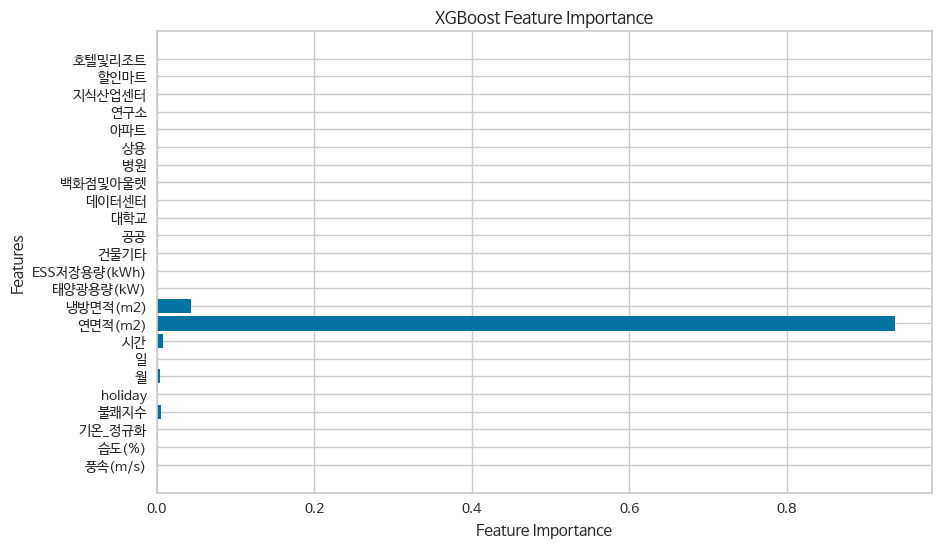

SMAPE: 7.04451


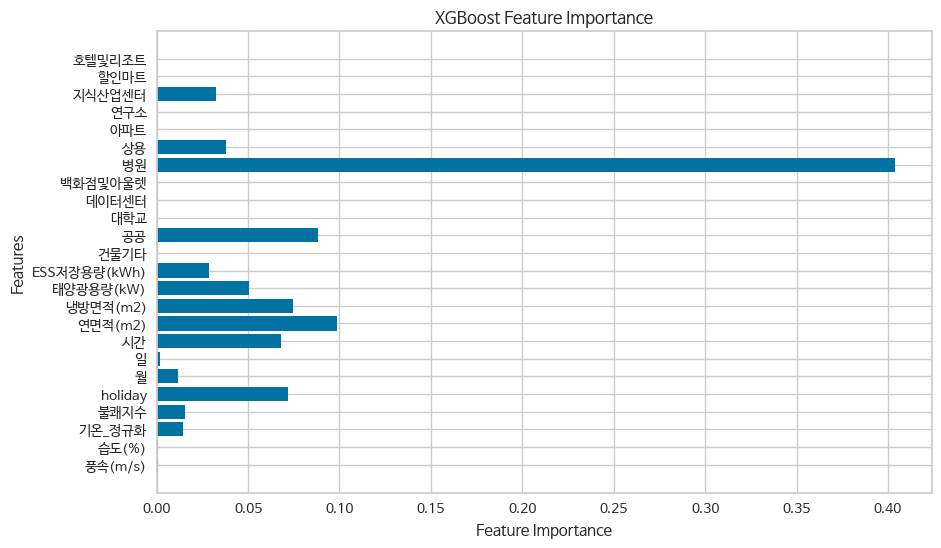

In [80]:

from pycaret.regression import *
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import joblib


# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():

    # Feature와 Target을 분리합니다.
    X = cluster_data[cluster].drop(columns=['전력소비량(kWh)','건물번호','km_cluster'])
    y = cluster_data[cluster]['전력소비량(kWh)']

    # Train과 Test 세트로 데이터를 분할합니다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGBoost 회귀 모델을 생성하고 학습합니다.
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)

    # 모델의 예측값을 생성합니다.
    y_pred = xgb_model.predict(X_test)

    # 학습한 모델 저장
    joblib.dump(xgb_model, '/content/drive/MyDrive/Colab Notebooks/dacon/xgb_model'+str(cluster)+'.pkl')

    # SMAPE를 계산하여 모델의 성능을 평가합니다.
    smape_score = smape_fnc(y_test, y_pred)
    print(f"SMAPE: {smape_score:.5f}")

    # 변수 중요도 출력
    plt.rc('font', family='NanumBarunGothic')
    plt.figure(figsize=(10, 6))
    plt.barh(X.columns, xgb_model.feature_importances_)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('XGBoost Feature Importance')
    plt.show()


In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/test.csv')

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(df, binfo_df, on='건물번호', how='left')

selected_columns = ['건물유형_라벨',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
test_df_final = test_df[selected_columns]

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df_final

In [72]:
from pycaret.regression import *
from sklearn.metrics import mean_squared_error

# 예측값을 저장할 컬럼
test_df_final['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():

    # 해당 클러스터의 모델 불러오기
    cluster_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/dacon/xgb_model'+str(cluster)+'.pkl')

    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_final[test_df_final['건물유형_라벨'].isin(building_labels)]
    cluster_test_data = cluster_test_data.drop(columns=['건물유형_라벨','answer'])
    index_list = cluster_test_data.index.tolist()

    # 불러온 모델로 예측 수행
    predictions = cluster_model.predict(cluster_test_data)

    # index_list와 predictions를 이용하여 데이터프레임 생성
    answer_df = pd.DataFrame({'answer': predictions}, index=index_list)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df_final.loc[answer_df.index, 'answer'] = answer_df['answer']



test_df_final

,건물유형_라벨,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),answer
0,1,2.2,72,0.562189,71.78980,False,8,25,0,110634.00,39570.00,0.0,0.0,1681.241577
1,1,0.9,72,0.537313,71.02840,False,8,25,1,110634.00,39570.00,0.0,0.0,1608.269897
2,1,1.5,75,0.522388,70.81675,False,8,25,2,110634.00,39570.00,0.0,0.0,1611.203979
3,1,1.3,78,0.492537,70.11262,False,8,25,3,110634.00,39570.00,0.0,0.0,1612.161743
4,1,1.0,77,0.477612,69.56514,False,8,25,4,110634.00,39570.00,0.0,0.0,1588.878296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,12,0.9,84,0.512438,71.22400,False,8,31,19,57497.84,40035.23,0.0,0.0,905.158142
16796,12,0.4,95,0.422886,68.95035,False,8,31,20,57497.84,40035.23,0.0,0.0,817.188354
16797,12,0.4,98,0.398010,68.24604,False,8,31,21,57497.84,40035.23,0.0,0.0,735.809509
16798,12,1.1,97,0.393035,68.01203,False,8,31,22,57497.84,40035.23,0.0,0.0,632.796326


In [73]:
sum(test_df_final['answer'].isna())

0

In [74]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = test_df_final['answer']
df.to_csv('submit_clust_xgb_noOneHot.csv', index=False)

### 각 군집별로 모델 생성(et)

In [81]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'km_cluster',
 'datetime']

In [ ]:
selected_columns = ['건물번호',
 'km_cluster',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
combined_clust_train_df = combined_clust_df[selected_columns]

cluster_data = []
for cluster_id in range(4):
    cluster_data.append(combined_clust_train_df[combined_clust_train_df['km_cluster'] == cluster_id].reset_index(drop=True))

cluster_data

In [84]:
cluster_data[1]

,건물번호,km_cluster,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,37,1,0.9,42.0,947.40,0.314815,63.09388,True,6,1,...,0,0,1,0,0,0,0,0,0,0
1,37,1,1.1,45.0,890.40,0.292593,62.46400,True,6,1,...,0,0,1,0,0,0,0,0,0,0
2,37,1,1.5,45.0,885.60,0.281481,62.08735,True,6,1,...,0,0,1,0,0,0,0,0,0,0
3,37,1,1.4,48.0,880.20,0.244444,60.89884,True,6,1,...,0,0,1,0,0,0,0,0,0,0
4,37,1,2.8,43.0,888.00,0.307407,62.88788,True,6,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32635,100,1,0.9,86.0,881.04,0.481481,72.38034,False,8,24,...,0,0,0,0,0,0,0,0,0,1
32636,100,1,1.3,86.0,798.96,0.455556,71.21736,False,8,24,...,0,0,0,0,0,0,0,0,0,1
32637,100,1,1.0,92.0,825.12,0.414815,69.79704,False,8,24,...,0,0,0,0,0,0,0,0,0,1
32638,100,1,0.3,94.0,640.08,0.403704,69.41060,False,8,24,...,0,0,0,0,0,0,0,0,0,1


In [85]:
cluster_data[1].columns.tolist()

['건물번호',
 'km_cluster',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

In [87]:
for i in tqdm(range(len(cluster_data))):

  # pycaret 설정
  exp1 = setup(data=cluster_data[i], target='전력소비량(kWh)', ignore_features=['건물번호','km_cluster'])

  # 모델 생성
  clust_model = create_model('et')

  # 모델 저장
  save_model(clust_model, '/content/drive/MyDrive/Colab Notebooks/dacon/model_clust_et'+ str(i))

  0%|          | 0/4 [00:00<?, ?it/s]

,Description,Value
0,Session id,3628
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 27)"
4,Transformed data shape,"(79560, 25)"
5,Transformed train set shape,"(55692, 25)"
6,Transformed test set shape,"(23868, 25)"
7,Ignore features,2
8,Numeric features,23
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,109.2951,44402.9698,210.7201,0.9956,0.1011,0.0566
1,111.8521,48786.6854,220.8771,0.9950,0.1040,0.0571
2,111.1920,46494.3368,215.6255,0.9955,0.1006,0.0562
3,109.3938,46257.3608,215.0752,0.9955,0.0999,0.0547
4,112.2010,51716.9389,227.4136,0.9947,0.1041,0.0574
5,107.9258,41235.4209,203.0651,0.9961,0.0966,0.0544
6,112.2016,48469.8479,220.1587,0.9950,0.0994,0.0552
7,108.8200,46041.7343,214.5734,0.9954,0.0963,0.0542
8,113.5370,46604.6446,215.8811,0.9957,0.1068,0.0585


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [04:47<14:21, 287.29s/it]

Transformation Pipeline and Model Successfully Saved


,Description,Value
0,Session id,7791
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(32640, 27)"
4,Transformed data shape,"(32640, 25)"
5,Transformed train set shape,"(22848, 25)"
6,Transformed test set shape,"(9792, 25)"
7,Ignore features,2
8,Numeric features,23
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,91.7764,40573.4150,201.4284,0.9793,0.1025,0.0606
1,89.0919,38101.3103,195.1956,0.9797,0.1263,0.0678
2,84.0173,30014.5473,173.2471,0.9836,0.1041,0.0595
3,88.9866,38179.3333,195.3953,0.9794,0.1227,0.0659
4,89.7434,39081.5312,197.6905,0.9788,0.1100,0.0618
5,85.2444,25092.1730,158.4051,0.9868,0.1074,0.0606
6,88.2554,31295.7220,176.9060,0.9833,0.1815,0.0626
7,86.8825,28963.9161,170.1879,0.9845,0.1001,0.0588
8,87.4169,33585.4268,183.2633,0.9809,0.1128,0.0631


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [06:13<05:37, 168.80s/it]

Transformation Pipeline and Model Successfully Saved


,Description,Value
0,Session id,5210
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(26520, 27)"
4,Transformed data shape,"(26520, 25)"
5,Transformed train set shape,"(18564, 25)"
6,Transformed test set shape,"(7956, 25)"
7,Ignore features,2
8,Numeric features,23
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,36.8666,4369.2388,66.1002,0.9995,0.0432,0.0253
1,34.3178,3690.8541,60.7524,0.9995,0.0384,0.0231
2,37.0163,4475.4419,66.8987,0.9994,0.0422,0.0245
3,35.8409,3975.0840,63.0483,0.9995,0.0405,0.0241
4,33.8452,3568.5700,59.7375,0.9996,0.0373,0.0227
5,34.9786,3750.1800,61.2387,0.9996,0.0408,0.0240
6,33.4921,3235.8333,56.8844,0.9996,0.0382,0.0233
7,35.0914,3999.9751,63.2454,0.9995,0.0403,0.0243
8,36.8593,4818.4435,69.4150,0.9994,0.0445,0.0254


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


 75%|███████▌  | 3/4 [07:17<02:00, 120.94s/it]

,Description,Value
0,Session id,3414
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(65280, 27)"
4,Transformed data shape,"(65280, 25)"
5,Transformed train set shape,"(45696, 25)"
6,Transformed test set shape,"(19584, 25)"
7,Ignore features,2
8,Numeric features,23
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:00:23
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,71.6055,15686.9813,125.2477,0.9905,0.0673,0.0384
1,75.4974,17229.7880,131.2623,0.9896,0.0712,0.0407
2,75.1015,18116.7715,134.5986,0.9881,0.0729,0.0409
3,72.7157,14741.2312,121.4135,0.9909,0.0667,0.0390
4,75.0136,15755.3847,125.5205,0.9897,0.0681,0.0397
5,74.5290,16854.0108,129.8230,0.9890,0.0691,0.0400
6,74.4331,17434.8480,132.0411,0.9889,0.0693,0.0394
7,72.8130,15194.1107,123.2644,0.9905,0.0666,0.0389
8,73.0410,16948.7703,130.1874,0.9890,0.0688,0.0393


100%|██████████| 4/4 [10:19<00:00, 154.98s/it]

Transformation Pipeline and Model Successfully Saved


In [88]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/test.csv')

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(df, binfo_df, on='건물번호', how='left')

selected_columns = ['건물유형_라벨',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
test_df_final = test_df[selected_columns]

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df_final

,건물유형_라벨,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,1,2.2,72,0.562189,71.78980,False,8,25,0,110634.00,...,0,0,0,0,0,0,0,0,0,0
1,1,0.9,72,0.537313,71.02840,False,8,25,1,110634.00,...,0,0,0,0,0,0,0,0,0,0
2,1,1.5,75,0.522388,70.81675,False,8,25,2,110634.00,...,0,0,0,0,0,0,0,0,0,0
3,1,1.3,78,0.492537,70.11262,False,8,25,3,110634.00,...,0,0,0,0,0,0,0,0,0,0
4,1,1.0,77,0.477612,69.56514,False,8,25,4,110634.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,12,0.9,84,0.512438,71.22400,False,8,31,19,57497.84,...,0,0,0,0,0,0,0,0,0,1
16796,12,0.4,95,0.422886,68.95035,False,8,31,20,57497.84,...,0,0,0,0,0,0,0,0,0,1
16797,12,0.4,98,0.398010,68.24604,False,8,31,21,57497.84,...,0,0,0,0,0,0,0,0,0,1
16798,12,1.1,97,0.393035,68.01203,False,8,31,22,57497.84,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
test_df_final.columns.tolist()

['건물유형_라벨',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

Transformation Pipeline and Model Successfully Loaded


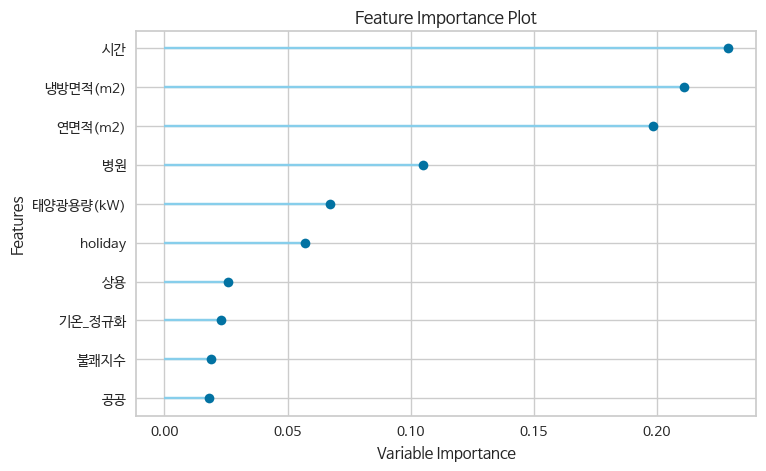

Transformation Pipeline and Model Successfully Loaded


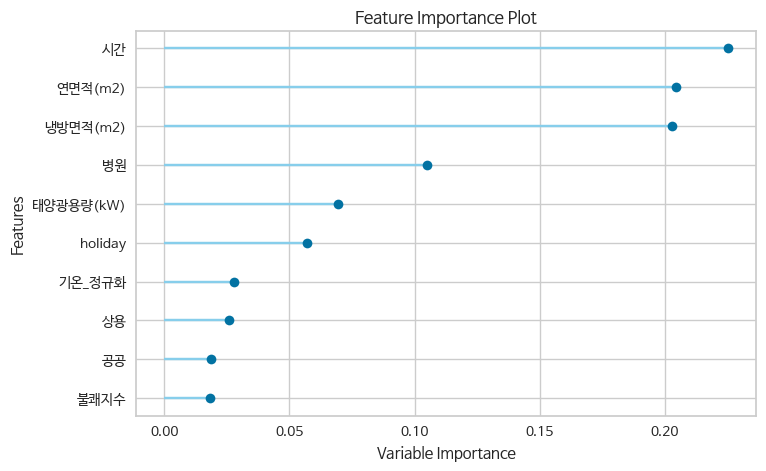

Transformation Pipeline and Model Successfully Loaded


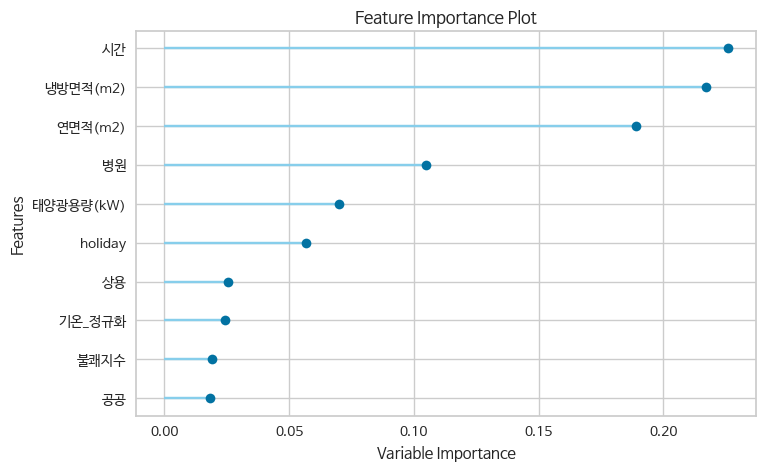

Transformation Pipeline and Model Successfully Loaded


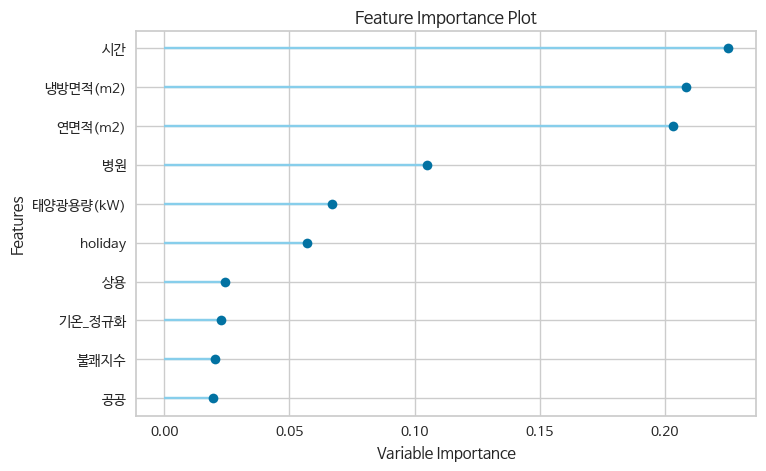

,건물유형_라벨,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),...,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,answer
0,1,2.2,72,0.562189,71.78980,False,8,25,0,110634.00,...,0,0,0,0,0,0,0,0,0,725.634000
1,1,0.9,72,0.537313,71.02840,False,8,25,1,110634.00,...,0,0,0,0,0,0,0,0,0,687.403800
2,1,1.5,75,0.522388,70.81675,False,8,25,2,110634.00,...,0,0,0,0,0,0,0,0,0,667.926603
3,1,1.3,78,0.492537,70.11262,False,8,25,3,110634.00,...,0,0,0,0,0,0,0,0,0,657.757799
4,1,1.0,77,0.477612,69.56514,False,8,25,4,110634.00,...,0,0,0,0,0,0,0,0,0,766.828804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,12,0.9,84,0.512438,71.22400,False,8,31,19,57497.84,...,0,0,0,0,0,0,0,0,1,1562.159399
16796,12,0.4,95,0.422886,68.95035,False,8,31,20,57497.84,...,0,0,0,0,0,0,0,0,1,1336.616402
16797,12,0.4,98,0.398010,68.24604,False,8,31,21,57497.84,...,0,0,0,0,0,0,0,0,1,1116.012594
16798,12,1.1,97,0.393035,68.01203,False,8,31,22,57497.84,...,0,0,0,0,0,0,0,0,1,1047.505203


In [89]:
from pycaret.regression import *
from sklearn.metrics import mean_squared_error

# 모델들이 저장된 디렉토리 경로
model_directory = '/content/drive/MyDrive/Colab Notebooks/dacon/'

# 예측값을 저장할 컬럼
test_df_final['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():
    # 해당 클러스터의 모델 불러오기
    cluster_model = load_model(model_directory + 'model_clust_et' + str(cluster))

    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_final[test_df_final['건물유형_라벨'].isin(building_labels)]
    cluster_test_data = cluster_test_data.drop(columns=['건물유형_라벨', 'answer'])

    # 테스트 데이터로 예측 수행
    final_model = finalize_model(cluster_model)
    predictions = predict_model(final_model, cluster_test_data)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df_final.loc[predictions.index, 'answer'] = predictions['prediction_label']

    # 변수 중요도 시각화
    plot_model(final_model, plot='feature')


test_df_final

In [91]:
predictions

,풍속(m/s),습도(%),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),냉방면적(m2),...,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,prediction_label
2520,0.8,88,0.412935,68.180603,False,8,25,0,240038.000000,95175.000000,...,0,0,0,0,0,0,0,0,0,1264.903188
2521,0.5,89,0.402985,67.902328,False,8,25,1,240038.000000,95175.000000,...,0,0,0,0,0,0,0,0,0,1268.318391
2522,0.9,89,0.402985,67.902328,False,8,25,2,240038.000000,95175.000000,...,0,0,0,0,0,0,0,0,0,1245.604199
2523,0.1,93,0.378109,67.268860,False,8,25,3,240038.000000,95175.000000,...,0,0,0,0,0,0,0,0,0,1270.353593
2524,0.4,94,0.363184,66.799698,False,8,25,4,240038.000000,95175.000000,...,0,0,0,0,0,0,0,0,0,1626.393605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14107,1.1,84,0.507463,71.059837,False,8,31,19,174408.203125,109973.101562,...,0,0,0,0,0,0,1,0,0,1866.730797
14108,0.8,86,0.462687,69.722099,False,8,31,20,174408.203125,109973.101562,...,0,0,0,0,0,0,1,0,0,1673.717998
14109,0.9,86,0.477612,70.220520,False,8,31,21,174408.203125,109973.101562,...,0,0,0,0,0,0,1,0,0,1470.196797
14110,0.4,93,0.442786,69.518768,False,8,31,22,174408.203125,109973.101562,...,0,0,0,0,0,0,1,0,0,1279.742411


In [90]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = test_df_final['answer']
df.to_csv('submit_clust_et.csv', index=False)

##pycaret

In [ ]:

# pycaret 설정
exp1 = setup(data=combined_df, target='전력소비량(kWh)')

# 모델 학습 및 비교
best_model = compare_models()

# 결과 출력
print(best_model)


In [ ]:
# 모델 생성
et_model = create_model('et')
#rf_model = create_model('rf')
#dt_model = create_model('dt')

In [ ]:
# 선택한 모델 튜닝
#et_tune_model = tune_model(et_model)
#rf_tune_model = tune_model('rf')
#dt_tune_model = tune_model('dt')


In [ ]:
# 모델 저장
save_model(rf_model, 'rf_model_saved')

In [ ]:
# 변수 중요도 그래프
plot_model(estimator = et_model, plot = 'feature')

# 모델 평가
evaluate_model(et_model)

In [ ]:
# 예측
et_final = finalize_model(rf_model)
pred = predict_model(et_final,test_df)

In [ ]:
pred

,풍속(m/s),습도(%),불쾌지수,기온_정규화,holiday,월,일,시간,연면적(m2),냉방면적(m2),...,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,prediction_label
0,2.2,72,71.789803,0.562189,False,8,25,0,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,2147.808015
1,0.9,72,71.028397,0.537313,False,8,25,1,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,2174.399982
2,1.5,75,70.816750,0.522388,False,8,25,2,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,2022.441615
3,1.3,78,70.112617,0.492537,False,8,25,3,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,1986.705614
4,1.0,77,69.565140,0.477612,False,8,25,4,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,1975.977611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,0.9,84,71.223999,0.512438,False,8,31,19,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,937.954191
16796,0.4,95,68.950348,0.422886,False,8,31,20,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,837.597007
16797,0.4,98,68.246040,0.398010,False,8,31,21,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,853.410597
16798,1.1,97,68.012032,0.393035,False,8,31,22,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,685.456815


In [ ]:
pred.columns.tolist()

['풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '기온_정규화',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 'prediction_label']

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = pred['prediction_label']
df.to_csv('submit_et.csv', index=False)

## 알고리즘

In [31]:
combined_df.columns.tolist()

['풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

# Feature와 Target을 분리합니다.
X = combined_df.drop(columns=['전력소비량(kWh)'])
y = combined_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 모델의 성능 평가를 위해 SMAPE 함수를 정의합니다.
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 모델의 예측값을 생성합니다.
y_pred = xgb_model.predict(X_test)

# SMAPE를 계산하여 모델의 성능을 평가합니다.
smape_score = smape_fnc(y_test, y_pred)
print(f"SMAPE: {smape_score:.5f}")



SMAPE: 12.71718


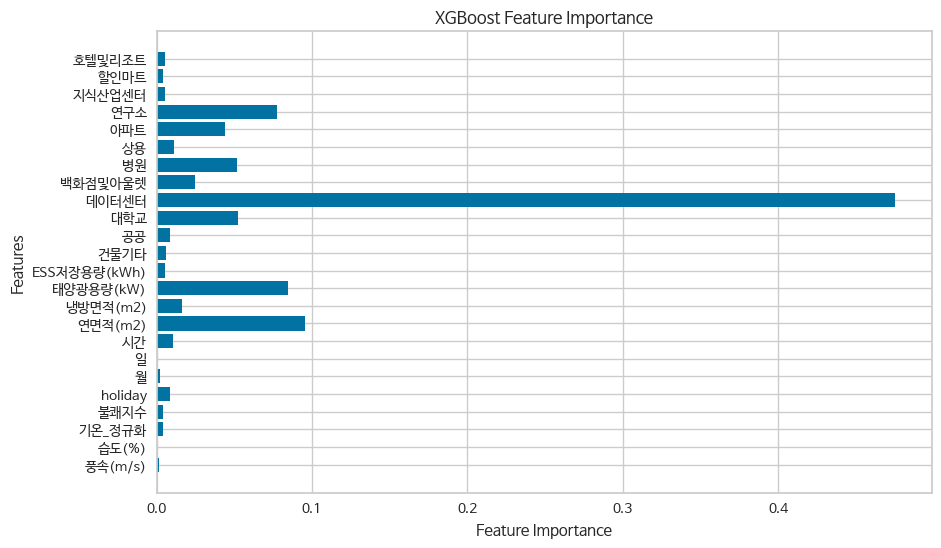

In [18]:
# 변수 중요도 출력
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

In [32]:
test_df.columns.tolist()

['건물번호',
 '풍속(m/s)',
 '습도(%)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

In [33]:
# 불러온 모델로 예측 수행
predictions = xgb_model.predict(test_df.drop(columns=['건물번호','건물유형_라벨','태양광여부']))
predictions

array([1503.8495 , 1455.1979 , 1453.6313 , ...,  776.20184,  589.0151 ,
        542.16266], dtype=float32)

In [35]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = predictions
df.to_csv('submit_xgb.csv', index=False)

## 스태킹

랜덤포레스트, svm, xgb

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# 데이터프레임에서 필요한 열만 선택
X = combined_df.drop(columns=['전력소비량(kWh)'])
y = combined_df['전력소비량(kWh)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR()
xgb_model = XGBRegressor()

# 스태킹 모델 생성
estimators = [('rf', rf_model), ('svm', svm_model), ('xgb', xgb_model)]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100, random_state=42))

# 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = stacking_model.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

smape = smape_fnc(y_test, y_pred)
print(f"smape: {smape}")


# test 예측
y_pred_submit = stacking_model.predict(test_df)



Extra Trees Regressor, Random Forest Regressor, Decision Tree Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 데이터프레임에서 필요한 열만 선택
X = combined_df.drop(columns=['전력소비량(kWh)'])
y = combined_df['전력소비량(kWh)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 모델 학습 및 예측
dt_regressor = DecisionTreeRegressor(random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
et_regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)

dt_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)
et_regressor.fit(X_train, y_train)

dt_pred = dt_regressor.predict(X_test)
rf_pred = rf_regressor.predict(X_test)
et_pred = et_regressor.predict(X_test)

# 기본 모델 예측 결과 저장
base_model_predictions = [dt_pred, rf_pred, et_pred]

# Meta 모델 학습 및 예측
meta_model = LinearRegression()
meta_model.fit(np.array(base_model_predictions).T, y_test)

stacked_predictions = meta_model.predict(np.array(base_model_predictions).T)

# 스태킹 모델의 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, stacked_predictions))
print(f"Stacking Model RMSE: {rmse}")


# test 예측
dt_pred_submit = dt_regressor.predict(test_df)
rf_pred_submit = rf_regressor.predict(test_df)
et_pred_submit = et_regressor.predict(test_df)

# 기본 모델 예측 결과 저장
base_model_predictions_submit = np.array([dt_pred_submit, rf_pred_submit, et_pred_submit]).T

# Meta 모델 학습 및 예측
stacked_predictions_submit = meta_model.predict(base_model_predictions_submit)


## 그래프

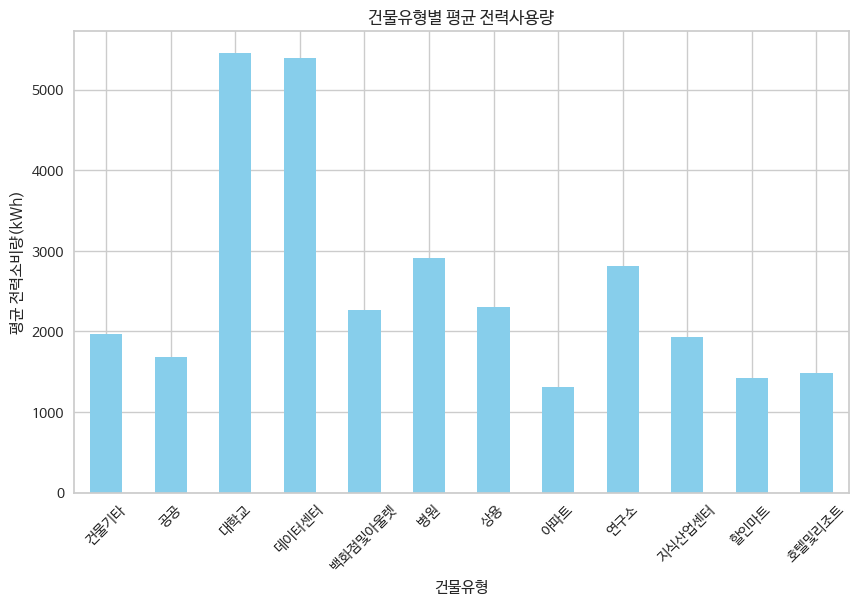

In [15]:
# 건물유형별 전력사용량의 평균 계산
mean_by_building_type = combined_df.groupby('건물유형')['전력소비량(kWh)'].mean()

# 그래프 그리기
plt.rc('font', family='NanumBarunGothic')
#plt.rc('font', family='')
plt.figure(figsize=(10, 6))
mean_by_building_type.plot(kind='bar', color='skyblue')
plt.title('건물유형별 평균 전력사용량')
plt.xlabel('건물유형')
plt.ylabel('평균 전력소비량(kWh)')
plt.xticks(rotation=45)
plt.show()

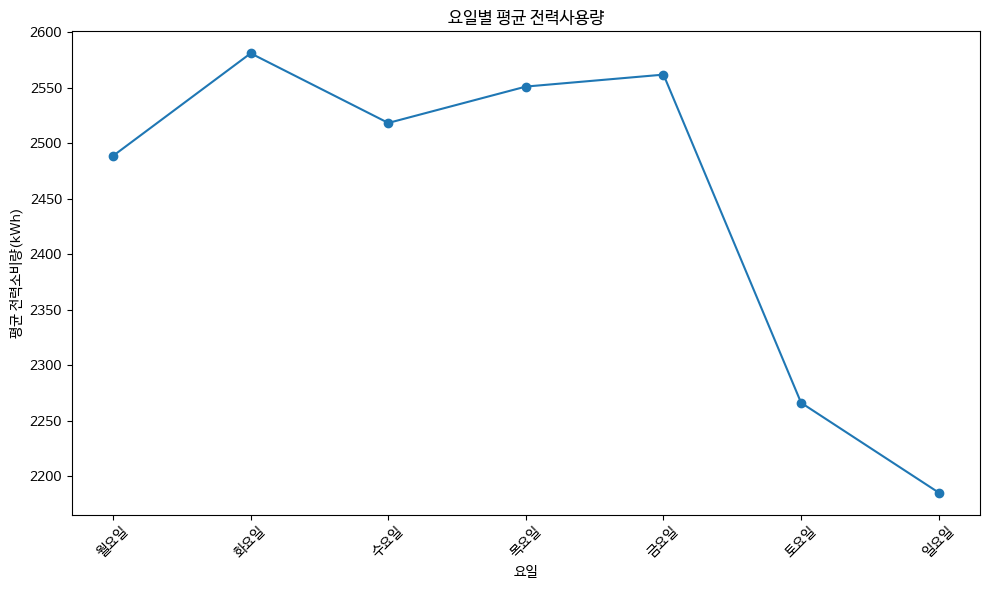

In [ ]:
# 요일별 전력사용량의 평균 계산
weekday_df = combined_df.copy()
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
weekday_df = weekday_df.groupby('요일')['전력소비량(kWh)'].mean().reindex(range(7))

plt.figure(figsize=(10, 6))
plt.plot(weekday_df.index, weekday_df.values, marker='o')
plt.xlabel('요일')
plt.ylabel('평균 전력소비량(kWh)')
plt.title('요일별 평균 전력사용량')
plt.xticks(range(7), weekday_order, rotation=45)
plt.tight_layout()
plt.show()

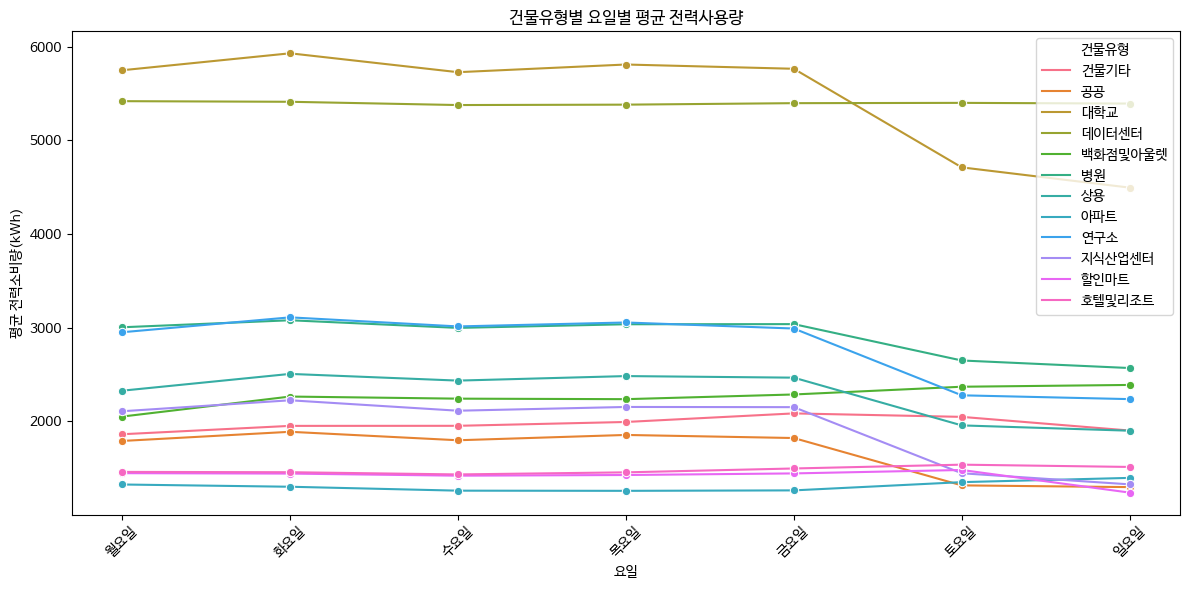

In [ ]:
# 건물유형별 요일별 평균 전력소비량 계산
building_type_weekday_df = combined_df.groupby(['건물유형', '요일'])['전력소비량(kWh)'].mean().reset_index()

# 요일 순서 설정
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=building_type_weekday_df, x='요일', y='전력소비량(kWh)', hue='건물유형', marker='o')

plt.xlabel('요일')
plt.ylabel('평균 전력소비량(kWh)')
plt.title('건물유형별 요일별 평균 전력사용량')
plt.xticks(range(7), weekday_order, rotation=45)  # X축 라벨을 요일명으로 설정하고 45도로 회전
plt.legend(title='건물유형')
plt.tight_layout()
plt.show()

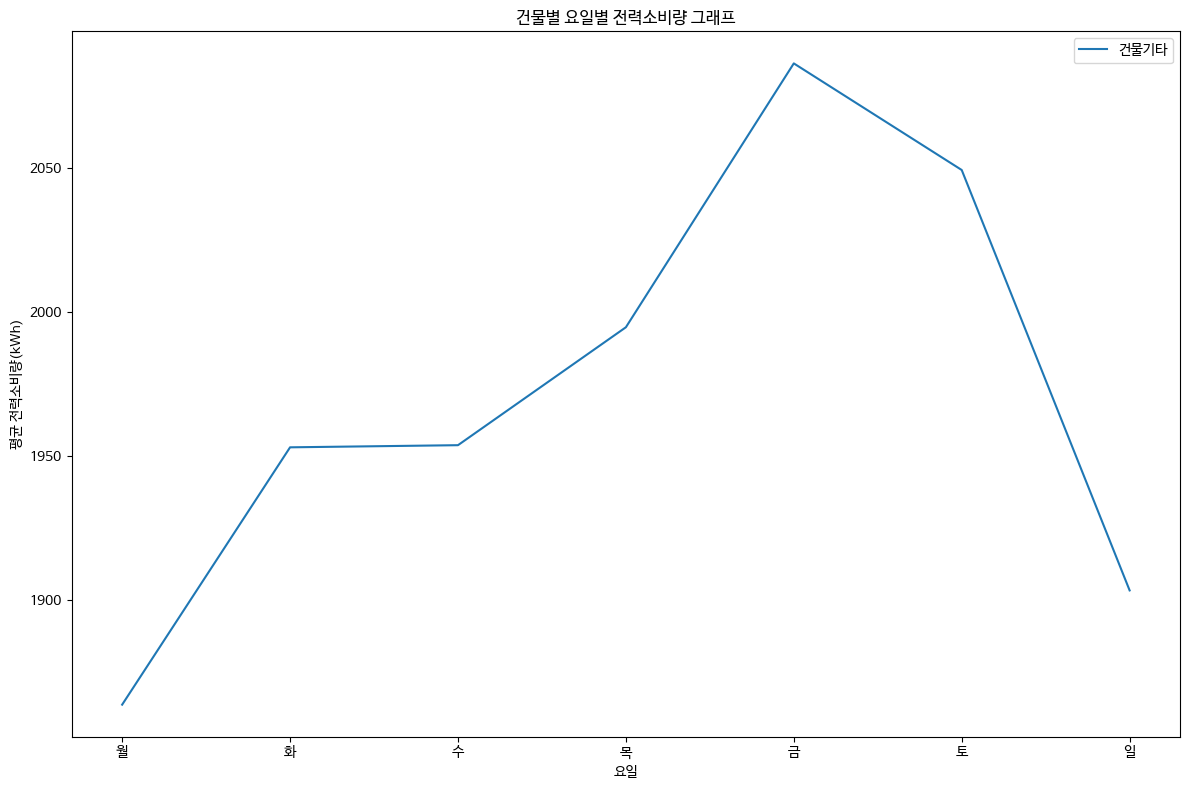

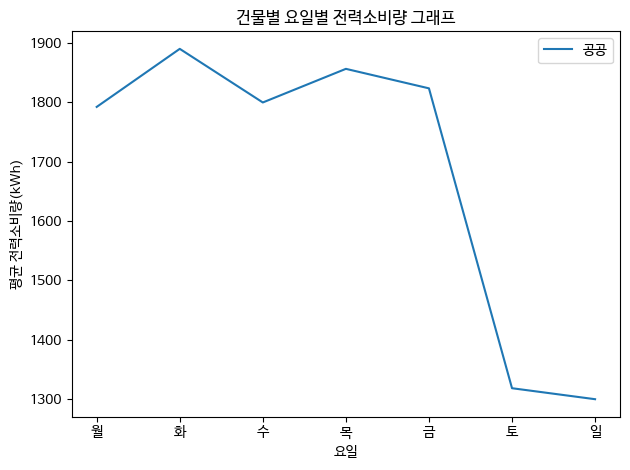

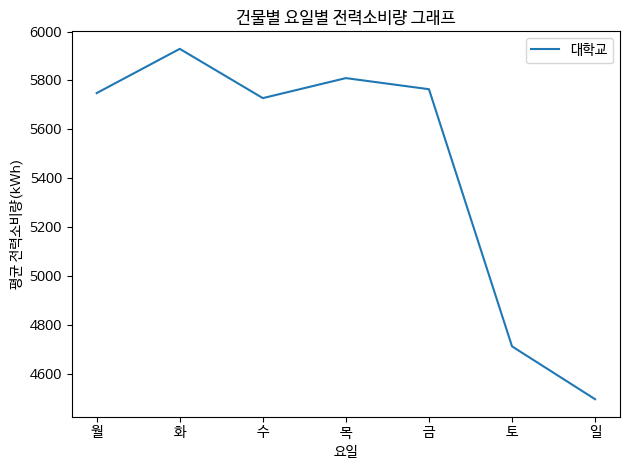

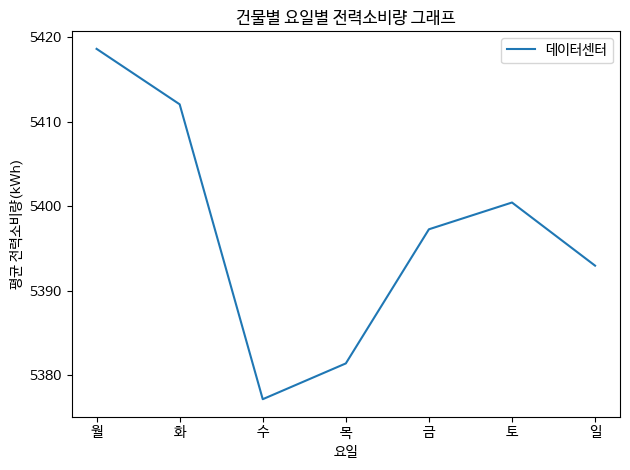

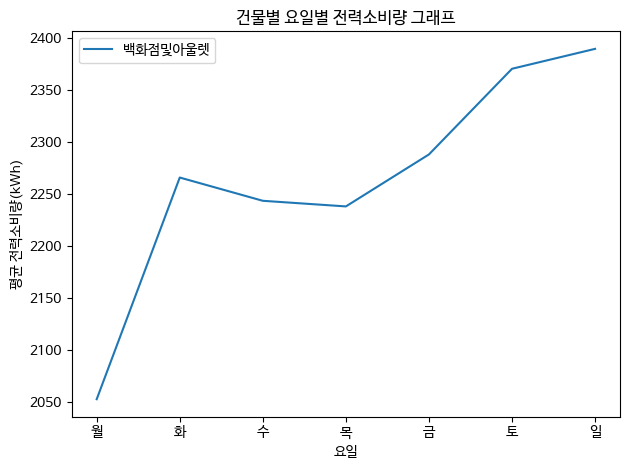

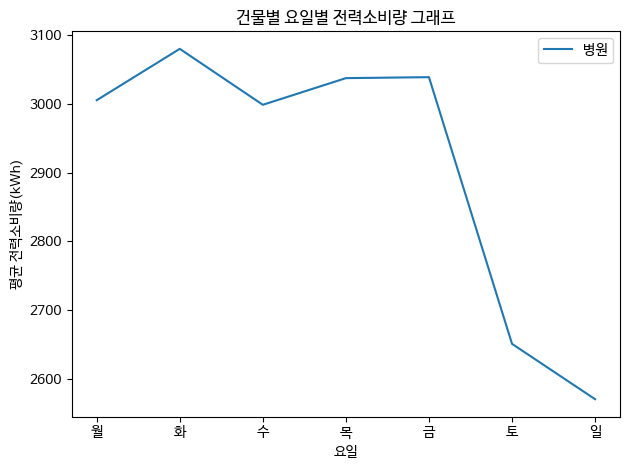

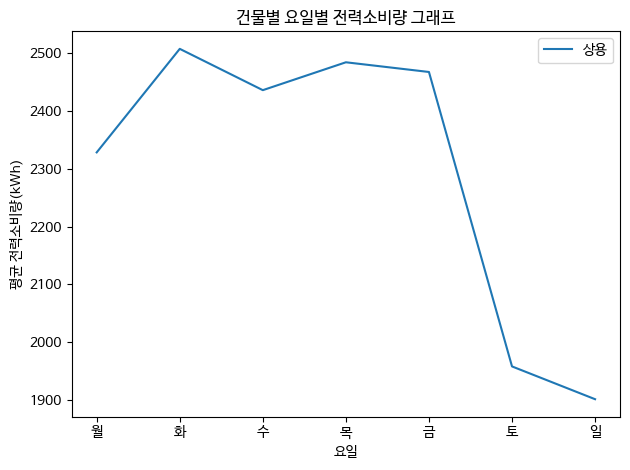

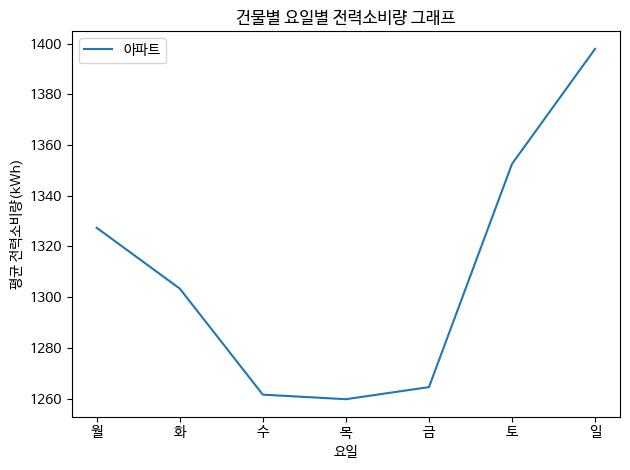

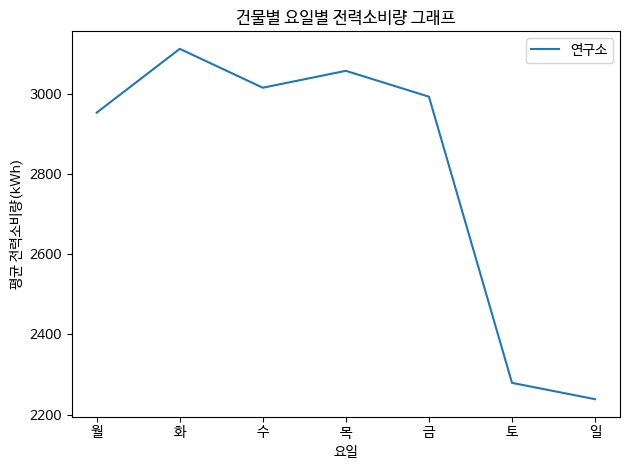

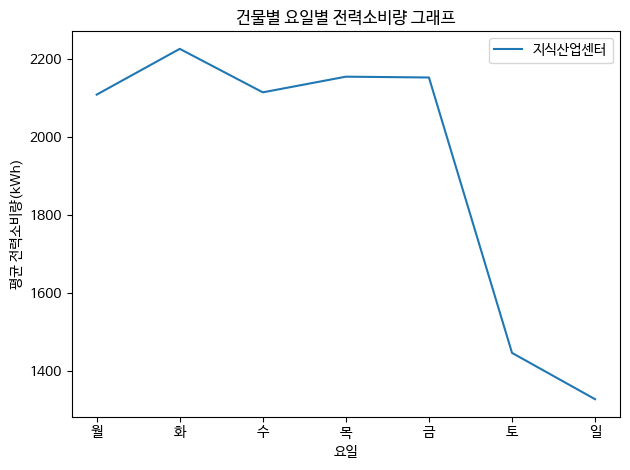

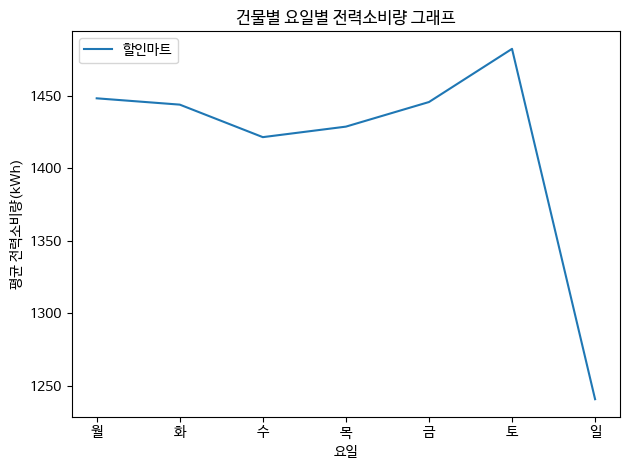

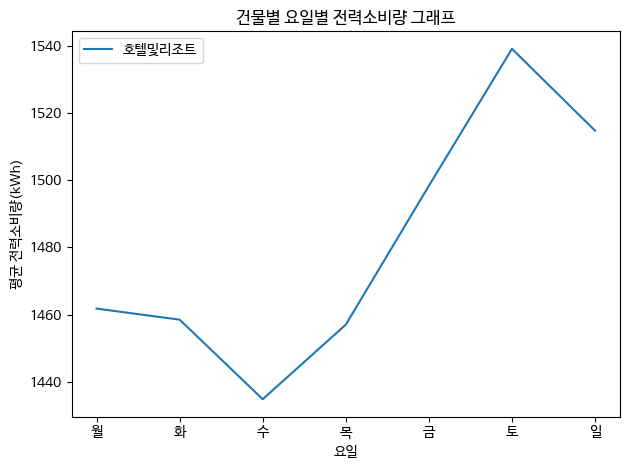

In [ ]:
# 건물별로 요일별 전력소비량 평균 계산
grouped = combined_df.groupby(['건물유형', '요일'])['전력소비량(kWh)'].mean().reset_index()

# 각 건물유형별로 요일별 전력소비량 그래프 그리기
unique_building_types = combined_df['건물유형'].unique()

plt.figure(figsize=(12, 8))
for building_type in unique_building_types:
    building_group = grouped[grouped['건물유형'] == building_type]
    plt.plot(building_group['요일'], building_group['전력소비량(kWh)'], label=building_type)

    plt.xlabel('요일')
    plt.ylabel('평균 전력소비량(kWh)')
    plt.title('건물별 요일별 전력소비량 그래프')
    plt.xticks(range(7), ['월', '화', '수', '목', '금', '토', '일'])  # X축 라벨을 요일명으로 설정
    plt.legend()
    plt.tight_layout()
    plt.show()